In [ ]:
import numpy as np
import pandas as pd

def correlated_garch_pair(
    n_days: int,
    params1: dict,
    params2: dict,
    rho_eps: float,
    seed: int = 0,
):
    """
    Simulate two correlated GARCH(1,1) return series.
    params{1,2} = dict(omega, alpha, beta)  with  alpha+beta < 1
    """
    rng = np.random.default_rng(seed)
    # Cholesky of 2×2 correlation matrix
    L = np.linalg.cholesky(np.array([[1, rho_eps], [rho_eps, 1]]))

    r1 = np.zeros(n_days)
    r2 = np.zeros(n_days)
    sig1 = np.full(n_days, np.sqrt(params1["omega"] / (1 - params1["alpha"] - params1["beta"])))
    sig2 = np.full(n_days, np.sqrt(params2["omega"] / (1 - params2["alpha"] - params2["beta"])))

    for t in range(1, n_days):
        # correlated i.i.d. N(0,1)
        z = rng.standard_normal(2)
        eps1, eps2 = L @ z

        r1[t] = sig1[t-1] * eps1
        r2[t] = sig2[t-1] * eps2

        sig1[t] = np.sqrt(
            params1["omega"]
            + params1["alpha"] * r1[t-1] ** 2
            + params1["beta"] * sig1[t-1] ** 2
        )
        sig2[t] = np.sqrt(
            params2["omega"]
            + params2["alpha"] * r2[t-1] ** 2
            + params2["beta"] * sig2[t-1] ** 2
        )

    return pd.DataFrame(
        {"r_core": r1, "r_repl": r2, "sigma_core": sig1, "sigma_repl": sig2}
    )

# --- example parameters ---------------------------------------------------
p1 = dict(omega=1e-6, alpha=0.05, beta=0.92)   # core stock
p2 = dict(omega=2e-6, alpha=0.04, beta=0.90)   # replacement
rho = 0.90

sim = correlated_garch_pair(1_000, p1, p2, rho_eps=rho)

print(sim[["r_core", "r_repl"]].corr())        # should be ~0.9


In [ ]:
# -----------------------------------------------------------
# Synthetic TLH price-series builder  —  with math import fixed
# -----------------------------------------------------------
import numpy as np
import pandas as pd
import math                       # ← NEW: needed for math.sqrt

# 1) GARCH simulator -------------------------------------------------------
def correlated_garch_pair(n, p1, p2, rho, seed=0):
    """
    Return two correlated GARCH(1,1) return arrays.
    """
    rng = np.random.default_rng(seed)
    L = np.linalg.cholesky(np.array([[1, rho], [rho, 1]]))

    r1 = np.zeros(n)
    r2 = np.zeros(n)

    sig1 = math.sqrt(p1["omega"] / (1 - p1["alpha"] - p1["beta"]))
    sig2 = math.sqrt(p2["omega"] / (1 - p2["alpha"] - p2["beta"]))

    for t in range(1, n):
        eps1, eps2 = L @ rng.standard_normal(2)
        r1[t] = sig1 * eps1
        r2[t] = sig2 * eps2

        sig1 = math.sqrt(
            p1["omega"] + p1["alpha"] * r1[t] ** 2 + p1["beta"] * sig1 ** 2
        )
        sig2 = math.sqrt(
            p2["omega"] + p2["alpha"] * r2[t] ** 2 + p2["beta"] * sig2 ** 2
        )
    return r1, r2

# 2) Parameter block -------------------------------------------------------
n_days = 252 * 2
dates  = pd.bdate_range("2023-01-03", periods=n_days)

p_core = dict(omega=1e-6, alpha=0.05, beta=0.92)
p_repl = dict(omega=2e-6, alpha=0.04, beta=0.90)
rho_eps = 0.90

r_core, r_repl = correlated_garch_pair(n_days, p_core, p_repl, rho_eps, seed=42)

# prices =  starting_price × exp(cum returns)
price_core = 300 * np.exp(np.cumsum(r_core))
price_repl = 150 * np.exp(np.cumsum(r_repl))

close_px = (
    pd.DataFrame({"date": np.tile(dates, 2),
                  "ticker": ["MSFT"] * n_days + ["VGT"] * n_days,
                  "close_px": np.concatenate([price_core, price_repl])})
)

# 3) Execution ledger ------------------------------------------------------
shares = 100
ledger = pd.DataFrame({
    "lot_id": ["L1"],
    "open_date": [dates[0]],
    "ticker": ["MSFT"],
    "shares": [shares],
    "cost_basis": [shares * price_core[0]],
})

# 4) Harvest rule (5 % drawdown) ------------------------------------------
drawdown = (price_core - price_core[0]) / price_core[0]
harvest_day = dates[np.where(drawdown < -0.05)[0][0]]

harvest = (
    pd.DataFrame({
        "date": [harvest_day],
        "lot_id": ["L1"],
        "core_ticker": ["MSFT"],
        "repl_ticker": ["VGT"],
    })
)
sell_px = price_core[(dates == harvest_day).argmax()]
loss    = shares * (sell_px - price_core[0])         # negative
harvest["realised_loss"] = loss
harvest["tax_credit"]    = -loss * 0.32              # + credit

# 5) Funding set to zero ---------------------------------------------------
funding_rates = pd.Series(0.0, index=dates, name="fund_rate")

# 6) Synthetic series builder ---------------------------------------------
def build_P(ledger, close_px, harvest, funding, P0=1_000_000):
    lots_daily = (
        ledger.merge(close_px, on="ticker")
              .sort_values(["lot_id", "date"])
    )
    lots_daily["value"] = lots_daily["shares"] * lots_daily["close_px"]
    lots_daily["dM"] = lots_daily.groupby("lot_id")["value"].diff().fillna(0)
    delta_M = lots_daily.groupby("date")["dM"].sum()

    L = harvest.set_index("date")["tax_credit"].reindex(delta_M.index).fillna(0)
    notional = lots_daily.groupby("date")["value"].sum().clip(lower=0)
    C = notional.shift(1).fillna(0) * funding / 252
    C = C.reindex(delta_M.index).fillna(0)

    P = P0 + (delta_M + L - C).cumsum()
    return pd.DataFrame({"P": P, "realised_credit": L, "funding": C})

P_series = build_P(ledger, close_px, harvest, funding_rates)

# 7) Quick preview ---------------------------------------------------------
print(P_series.head())
print("\nHarvest event:")
print(harvest)
print("\nSample return correlation:", np.corrcoef(r_core, r_repl)[0, 1])


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Monte‑Carlo simulation of a ONE‑PAIR TLH strategy over 1 year
# ------------------------------------------------------------
#  * Core ticker  A  (e.g., MSFT)
#  * Replacement  B  (e.g., VGT)
#  * Both returns are Gaussian with constant vol; shocks correlated.
#  * Harvest rule: realise loss when core drawdown from lot cost > 5 %.
#  * Immediately swap into replacement; hold replacement for 30 calendar
#    days (wash‑sale window); then switch back to core.
#  * Output distributions for:
#       – # harvests
#       – total realised loss (USD)
#       – tax credit (30 %)
#       – ending synthetic value  P_T
# ------------------------------------------------------------
np.random.seed(7)

# ------------ simulation parameters -------------------------
N_SIM  = 2000        # MC paths
DAYS   = 252         # trading days ≈ 1 year
dt     = 1/252
draw_threshold = 0.05
wash_days = 30
tax_rate = 0.30

S0_core, S0_repl = 300.0, 150.0
mu_core, mu_repl = 0.06, 0.05        # annual drifts
sigma_core, sigma_repl = 0.25, 0.22
rho = 0.90                           # shock correlation

# Cholesky for correlated normals
L = np.linalg.cholesky([[1, rho], [rho, 1]])

results = []

for sim in range(N_SIM):
    # --- initial state ---
    S_core  = S0_core
    S_repl  = S0_repl
    hold    = "core"      # 'core' or 'repl'
    days_to_core = 0
    cost_basis = S_core
    shares = 100                      # fixed shares
    synthetic = S_core * shares
    realised_loss_total = 0.0
    harvest_count = 0

    for t in range(1, DAYS+1):
        # simulate correlated daily returns
        eps = L @ np.random.normal(size=2)
        r_core = (mu_core - 0.5*sigma_core**2)*dt + sigma_core*np.sqrt(dt)*eps[0]
        r_repl = (mu_repl - 0.5*sigma_repl**2)*dt + sigma_repl*np.sqrt(dt)*eps[1]

        S_core  *= np.exp(r_core)
        S_repl  *= np.exp(r_repl)

        if hold == "core":
            mv = S_core * shares
            draw = (mv - cost_basis*shares)/(cost_basis*shares)
            if draw < -draw_threshold:
                # harvest
                realised_loss = (S_core - cost_basis) * shares
                realised_loss_total += realised_loss
                harvest_count += 1

                # sell core, buy replacement
                mv = S_core * shares
                shares_repl = mv / S_repl
                shares = shares_repl
                hold = "repl"
                days_to_core = wash_days
        else:
            # holding replacement
            days_to_core -= 1
            if days_to_core == 0:
                # switch back to core
                mv = S_repl * shares
                shares_core = mv / S_core
                shares = shares_core
                hold = "core"
                cost_basis = S_core  # reset basis

        # synthetic value tracked but not stored daily
        pass

    # final portfolio value
    P_T = S_core*shares if hold=="core" else S_repl*shares
    results.append({
        "harvests": harvest_count,
        "realised_loss": realised_loss_total,
        "tax_credit": -realised_loss_total * tax_rate,   # positive
        "P_T": P_T
    })

df = pd.DataFrame(results)

# ------------ summary statistics ----------------------------
summary = df.describe(percentiles=[.05, .5, .95]).T
display(summary)

# ------------ simple histograms -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(df["harvests"], bins=range(df["harvests"].max()+2),
             edgecolor="k", alpha=0.7)
axes[0].set_title("# Harvests")
axes[1].hist(df["tax_credit"], bins=30, edgecolor="k", alpha=0.7)
axes[1].set_title("Tax credit (USD)")
plt.tight_layout()
plt.show()


In [ ]:
# ==============================================================
# TLH Monte-Carlo — core vs. replacement, log-return GBM, fixed notional
# ==============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PARAMETERS ----------------------------------------------------
N_SIM   = 2000
DAYS    = 252               # 1 trading year
dt      = 1/252
mu_c, mu_r = 0.00, 0.00     # annual drifts
sig_c, sig_r = 0.25, 0.22
rho     = 0.85              # shock correlation
V0      = 30_000.0          # constant dollars invested
loss_thr= 0.05              # 5 % trigger
wash    = 30                # 30-day window
tax     = 0.30              # tax rate
rng     = np.random.default_rng(42)

# Cholesky for correlated N(0,1)
L = np.linalg.cholesky([[1, rho], [rho, 1]])

# helper: one GBM path -----------------------------------------
def gbm_pair():
    z = rng.standard_normal((DAYS, 2)) @ L.T
    r_core = (mu_c - 0.5*sig_c**2)*dt + sig_c*np.sqrt(dt)*z[:,0]   # log-returns
    r_repl = (mu_r - 0.5*sig_r**2)*dt + sig_r*np.sqrt(dt)*z[:,1]
    S_core = 300 * np.exp(np.cumsum(r_core))
    S_repl = 150 * np.exp(np.cumsum(r_repl))
    return S_core, S_repl

# MONTE-CARLO LOOP ---------------------------------------------
rec = []
for _ in range(N_SIM):
    S_c, S_r = gbm_pair()

    hold = "core"
    basis = S_c[0]
    days_in_repl = 0
    realised = 0.0
    n_harvest = 0

    for t in range(1, DAYS):
        if hold == "core":
            if (S_c[t]-basis)/basis < -loss_thr:
                realised += V0 * (S_c[t]-basis)/basis
                n_harvest += 1
                hold, days_in_repl = "repl", wash
        else:
            days_in_repl -= 1
            if days_in_repl == 0:
                hold, basis = "core", S_c[t]

    P_T = V0 * (S_c[-1]/S_c[0] if hold=="core" else S_r[-1]/S_r[0])
    rec.append({
        "harvests": n_harvest,
        "realised_loss": realised,
        "tax_credit": -tax*realised,
        "P_T": P_T
    })

df = pd.DataFrame(rec)

# RESULTS -------------------------------------------------------
print(df.describe(percentiles=[.05,.5,.95]).T)

fig, ax = plt.subplots(1,3,figsize=(12,4))
ax[0].hist(df["harvests"], bins=range(df["harvests"].max()+2),
           edgecolor="k"); ax[0].set_title("# harvests")
ax[1].hist(df["tax_credit"], bins=40, edgecolor="k");
ax[1].set_title("tax credit (USD)")
ax[2].hist(df["P_T"], bins=40, edgecolor="k");
ax[2].set_title("end value (USD)")
plt.tight_layout(); plt.show()


In [ ]:
# ==============================================================
# TLH Monte-Carlo — m staggered lots, log-return GBM, fixed notional
# ==============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- USER SETTINGS -------------------------------
N_SIM   = 2_000            # Monte-Carlo paths
DAYS    = 252              # 1 trading year
m       = 20                # <-- number of staggered sub-lots
dt      = 1/252
mu_c, mu_r   = 0.00, 0.00  # drifts (set to 0 ⇒ pure vol test)
sig_c, sig_r = 0.20, 0.22
rho     = 0.85
V0      = 30_000.0         # total notional (constant)
loss_thr= 0.05             # 2 % draw-down trigger
wash    = 30               # 30-day wash window
tax     = 0.30             # short-term rate
rng     = np.random.default_rng(42)

# --------------- correlated GBM helper ------------------------
L = np.linalg.cholesky([[1, rho], [rho, 1]])
def gbm_pair():
    z = rng.standard_normal((DAYS, 2)) @ L.T
    r_c = (mu_c - .5*sig_c**2)*dt + sig_c*np.sqrt(dt)*z[:,0]
    r_r = (mu_r - .5*sig_r**2)*dt + sig_r*np.sqrt(dt)*z[:,1]
    S_c = 300*np.exp(np.cumsum(r_c))
    S_r = 150*np.exp(np.cumsum(r_r))
    return S_c, S_r

# --------------- Monte-Carlo  ---------------------------------
results = []
lot_notional = V0 / m                 # dollars per lot

for _ in range(N_SIM):
    S_c, S_r = gbm_pair()

    # initialise m lots, staggered so lot j is “age=j” on day 0
    lots = [{"state": "core",
             "age"  : j,            # age in trading days
             "basis": S_c[0]}       # entry price
            for j in range(m)]
    realised = 0.0
    harvests = 0

    for t in range(1, DAYS):

        # update each lot independently
        for lot in lots:
            lot["age"] += 1

            if lot["state"] == "core":
                draw = (S_c[t] - lot["basis"]) / lot["basis"]
                if draw < -loss_thr and lot["age"] > wash:
                    # --- HARVEST ------------------------------------------------
                    realised += lot_notional * draw
                    harvests += 1
                    lot.update(state="repl", age=0)  # switch into replacement
            else:  # in replacement
                if lot["age"] > wash:
                    # --- SWITCH BACK -------------------------------------------
                    lot.update(state="core", basis=S_c[t], age=0)

    # end-of-year liquidation value
    val = 0.0
    for lot in lots:
        price = S_c[-1] if lot["state"] == "core" else S_r[-1]
        val  += lot_notional * price / (S_c[0] if lot["state"]=="core"
                                        else S_r[0])

    results.append({
        "harvests"      : harvests,
        "realised_loss" : realised,
        "tax_credit"    : -tax * realised,
        "P_T"           : val
    })

df = pd.DataFrame(results)

# --------------- SUMMARY & PLOTS ------------------------------
print(df.describe(percentiles=[.05,.5,.95]).T)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].hist(df["harvests"], bins=range(df["harvests"].max()+2),
           edgecolor="k"); ax[0].set_title("# harvests")
ax[1].hist(df["tax_credit"], bins=40, edgecolor="k")
ax[1].set_title("tax credit (USD)")
ax[2].hist(df["P_T"], bins=40, edgecolor="k")
ax[2].set_title("end value (USD)")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==============================================================
# TLH Monte-Carlo over m = 1..10 staggered lots, GBM, fixed notional
# (vectorized with correct broadcasting)
# ==============================================================

# User settings
N_SIM    = 250_000
DAYS     = 252
m_values = np.arange(1, 10)
dt       = 1/252
mu_c, mu_r   = 0.00, 0.00
sig_c, sig_r = 0.20, 0.22
rho      = 0.85
V0       = 30000.0
loss_thr = 0.05
wash     = 30
tax      = 0.30
rng      = np.random.default_rng(42)
L        = np.linalg.cholesky([[1, rho], [rho, 1]])

# 1) Simulate all GBM paths: S_core, S_repl shape (N_SIM, DAYS)
Z = rng.standard_normal((N_SIM, DAYS, 2)) @ L.T
r_c = (mu_c - 0.5*sig_c**2)*dt + sig_c*np.sqrt(dt)*Z[:,:,0]
r_r = (mu_r - 0.5*sig_r**2)*dt + sig_r*np.sqrt(dt)*Z[:,:,1]
S_core = 300 * np.exp(np.cumsum(r_c, axis=1))
S_repl = 150 * np.exp(np.cumsum(r_r, axis=1))

# Storage for statistics
stats = []

for m in m_values:
    lot_notional = V0 / m
    # Initialize state arrays
    state = np.zeros((N_SIM, m), dtype=bool)  # False=core, True=repl
    age   = np.tile(np.arange(m), (N_SIM, 1))
    basis = np.full((N_SIM, m), S_core[:, [0]])
    realised = np.zeros(N_SIM)
    harvest_count = np.zeros(N_SIM)

    # Daily updates
    for t in range(1, DAYS):
        # compute drawdowns
        draw = (S_core[:, t, None] - basis) / basis
        can_harvest = (~state) & (draw < -loss_thr) & (age > wash)
        realised += lot_notional * (draw * can_harvest).sum(axis=1)
        harvest_count += can_harvest.sum(axis=1)
        state[can_harvest] = True
        age[can_harvest]   = 0

        # increment age
        age += 1

        # switch back after wash
        can_switch = state & (age > wash)
        # broadcast day's core price
        price_mat = np.broadcast_to(S_core[:, t][:, None], basis.shape)
        basis[can_switch] = price_mat[can_switch]
        state[can_switch] = False
        age[can_switch]   = 0

    # Liquidation values
    final_price = np.where(~state, S_core[:, -1, None], S_repl[:, -1, None])
    start_price = np.where(~state, S_core[:, 0, None], S_repl[:, 0, None])
    P_T = (lot_notional * final_price / start_price).sum(axis=1)

    stats.append({
        "m": m,
        "mean_harvests": harvest_count.mean(),
        "mean_credit":   (-tax * realised).mean(),
        "mean_PT":      P_T.mean(),
        "std_PT":       P_T.std(ddof=1),
    })

df_stats = pd.DataFrame(stats)

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes[0,0].plot(df_stats["m"], df_stats["mean_harvests"], marker='o')
axes[0,0].set_title("Mean Harvests vs. m")
axes[0,0].set_xlabel("m (slots)")
axes[0,0].set_ylabel("Mean # harvests")

axes[0,1].plot(df_stats["m"], df_stats["mean_credit"], marker='o')
axes[0,1].set_title("Mean Tax Credit vs. m")
axes[0,1].set_xlabel("m (slots)")
axes[0,1].set_ylabel("Mean credit (USD)")

axes[1,0].plot(df_stats["m"], df_stats["mean_PT"], marker='o')
axes[1,0].set_title("Mean End Value P_T vs. m")
axes[1,0].set_xlabel("m (slots)")
axes[1,0].set_ylabel("Mean P_T (USD)")

axes[1,1].plot(df_stats["m"], df_stats["std_PT"], marker='o')
axes[1,1].set_title("Std Dev of P_T vs. m")
axes[1,1].set_xlabel("m (slots)")
axes[1,1].set_ylabel("Std Dev (USD)")

plt.tight_layout()
plt.show()

df_stats


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==============================================================
# TLH Monte-Carlo over m = 1..9 staggered lots, Heston, fixed notional
# (vectorized with correct broadcasting)
# ==============================================================

# User settings
N_SIM    = 20_000       # reduced for speed
DAYS     = 252         # 1 trading year
m_values = np.arange(1, 10)
dt       = 1/252.0
S0       = 300.0       # initial spot
r        = 0.035        # risk-free rate
# Heston params
v0       = 0.04        # initial variance
kappa    = 2.0         # mean reversion rate
theta    = 0.04        # long-term variance
xi       = 0.5         # vol-of-vol
rho      = -0.7        # correlation
V0       = 30_000.0     # total notional
loss_thr = 0.05
wash     = 30
tax      = 0.30

# Pre-generate correlated normals: shape (N_SIM, DAYS, 2)
rng = np.random.default_rng(42)
Z = rng.standard_normal((N_SIM, DAYS, 2))
L = np.linalg.cholesky([[1, rho], [rho, 1]])
Z = Z @ L.T

# Simulate Heston via Euler-Maruyama
S = np.zeros((N_SIM, DAYS+1))
v = np.zeros((N_SIM, DAYS+1))
S[:, 0] = S0
v[:, 0] = v0
for t in range(1, DAYS+1):
    z1 = Z[:, t-1, 0]
    z2 = Z[:, t-1, 1]
    vt = v[:, t-1]
    sqrt_vt = np.sqrt(np.maximum(vt, 0))
    v[:, t] = vt + kappa*(theta - vt)*dt + xi*sqrt_vt*np.sqrt(dt)*z2
    v[:, t] = np.maximum(v[:, t], 0)
    S[:, t] = S[:, t-1] * np.exp((r - 0.5*vt)*dt + sqrt_vt*np.sqrt(dt)*z1)

# Storage for statistics
stats = []

for m in m_values:
    lot_notional = V0 / m
    state = np.zeros((N_SIM, m), dtype=bool)
    age = np.tile(np.arange(m), (N_SIM, 1))
    basis = np.full((N_SIM, m), S[:, 0][:, None])
    realised = np.zeros(N_SIM)
    harvest_count = np.zeros(N_SIM)

    for t in range(1, DAYS+1):
        St = S[:, t]
        # broadcast current price to match basis shape
        price_mat = np.broadcast_to(St[:, None], basis.shape)
        draw = (price_mat - basis) / basis
        can_harvest = (~state) & (draw < -loss_thr) & (age > wash)
        realised += lot_notional * (draw * can_harvest).sum(axis=1)
        harvest_count += can_harvest.sum(axis=1)
        state[can_harvest] = True
        age[can_harvest] = 0

        age += 1
        can_switch = state & (age > wash)
        state[can_switch] = False
        basis[can_switch] = price_mat[can_switch]
        age[can_switch] = 0

    # Liquidation value (use final S for both core/repl for simplicity)
    price_mat_last = np.broadcast_to(S[:, -1][:, None], basis.shape)
    start_mat = np.broadcast_to(S[:, 0][:, None], basis.shape)
    P_T = (lot_notional * price_mat_last / start_mat).sum(axis=1)

    stats.append({
        "m": m,
        "mean_harvests": harvest_count.mean(),
        "mean_credit":   (-tax * realised).mean(),
        "mean_PT":       P_T.mean(),
        "std_PT":        P_T.std(ddof=1),
    })

df_stats = pd.DataFrame(stats)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(12,8))
axes[0,0].plot(df_stats.m, df_stats.mean_harvests, 'o-')
axes[0,0].set_title("Mean Harvests vs m")
axes[0,1].plot(df_stats.m, df_stats.mean_credit, 'o-')
axes[0,1].set_title("Mean Tax Credit vs m")
axes[1,0].plot(df_stats.m, df_stats.mean_PT, 'o-')
axes[1,0].set_title("Mean P_T vs m")
axes[1,1].plot(df_stats.m, df_stats.std_PT, 'o-')
axes[1,1].set_title("StdDev P_T vs m")
plt.tight_layout()
plt.show()

df_stats


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==============================================================
# TLH Monte-Carlo over m = 1..9 staggered lots, joint Heston, fixed notional
# ==============================================================

# User settings
N_SIM    = 200_000       # Monte-Carlo paths
DAYS     = 252          # trading days in 1 year
m_values = np.arange(1, 10)
dt       = 1/252.0
S0_c     = 300.0        # initial core spot
S0_r     = 150.0        # initial replacement spot
r        = 0.035        # risk-free rate

# Heston parameters (core and replacement share same parameters)
# -------------------------------------------------------------
# v0      : initial variance (must be > 0)
# kappa   : mean‐reversion rate (must be > 0)
# theta   : long‐run variance (must be ≥ 0)
# xi      : volatility of volatility (must be ≥ 0)
# rho_c   : correlation between core price and its variance driver (|rho_c| < 1)
# rho_r   : correlation between repl price and its variance driver (|rho_r| < 1)
# rho_cr  : cross‐asset price correlation (must satisfy
#           |rho_cr| ≤ sqrt((1−rho_c²)(1−rho_r²)) to keep the 4×4 covariance matrix PD)

v0       = 0.04         # initial variance
kappa    = 2.0          # mean reversion rate
theta    = 0.04         # long-term variance
xi       = 0.5          # vol-of-vol
rho_c    = -0.7         # core price-vol correlation
rho_r    = -0.7         # repl price-vol correlation
rho_cr   = 0.5          # cross-asset price correlation

V0       = 30_000.0     # total notional (fixed)
loss_thr = 0.05         # drawdown trigger
wash     = 30           # wash window in days
tax      = 0.30         # tax rate

# 1) Build 4×4 correlation matrix and its Cholesky
C = np.array([
    [1,      rho_c, rho_cr,   0    ],
    [rho_c,  1,     0,        0    ],
    [rho_cr, 0,     1,      rho_r  ],
    [0,      0,     rho_r,    1    ]
])
L4 = np.linalg.cholesky(C)

# 2) Pre-generate correlated normals: shape (N_SIM, DAYS, 4)
rng = np.random.default_rng(42)
Z4 = rng.standard_normal((N_SIM, DAYS, 4)) @ L4.T

# 3) Simulate joint Heston paths via Euler-Maruyama
S_c = np.zeros((N_SIM, DAYS+1)); v_c = np.zeros_like(S_c)
S_r = np.zeros_like(S_c);           v_r = np.zeros_like(S_c)
S_c[:,0] = S0_c; v_c[:,0] = v0
S_r[:,0] = S0_r; v_r[:,0] = v0

for t in range(1, DAYS+1):
    # correlated increments
    dW1_c = Z4[:, t-1, 0] * np.sqrt(dt)
    dW2_c = Z4[:, t-1, 1] * np.sqrt(dt)
    dW1_r = Z4[:, t-1, 2] * np.sqrt(dt)
    dW2_r = Z4[:, t-1, 3] * np.sqrt(dt)
    
    # core updates
    vc = v_c[:, t-1]
    sqrt_vc = np.sqrt(np.maximum(vc, 0))
    v_c[:, t] = vc + kappa*(theta - vc)*dt + xi*sqrt_vc*dW2_c
    v_c[:, t] = np.maximum(v_c[:, t], 0)
    S_c[:, t] = S_c[:, t-1] * np.exp((r - 0.5*vc)*dt + sqrt_vc*dW1_c)
    
    # replacement updates
    vr = v_r[:, t-1]
    sqrt_vr = np.sqrt(np.maximum(vr, 0))
    v_r[:, t] = vr + kappa*(theta - vr)*dt + xi*sqrt_vr*dW2_r
    v_r[:, t] = np.maximum(v_r[:, t], 0)
    S_r[:, t] = S_r[:, t-1] * np.exp((r - 0.5*vr)*dt + sqrt_vr*dW1_r)

# 4) TLH logic per m
stats = []
for m in m_values:
    lot_notional = V0 / m
    state = np.zeros((N_SIM, m), dtype=bool)  # False=core, True=repl
    age   = np.tile(np.arange(m), (N_SIM, 1))
    basis = np.full((N_SIM, m), S_c[:, [0]])
    realised = np.zeros(N_SIM)
    harvest_count = np.zeros(N_SIM)
    
    for t in range(1, DAYS+1):
        # current prices broadcast
        price_c = np.broadcast_to(S_c[:, t][:, None], basis.shape)
        price_r = np.broadcast_to(S_r[:, t][:, None], basis.shape)
        
        # drawdown and harvesting on core lots
        draw = (price_c - basis) / basis
        can_h = (~state) & (draw < -loss_thr) & (age > wash)
        realised += lot_notional * (draw * can_h).sum(axis=1)
        harvest_count += can_h.sum(axis=1)
        state[can_h] = True
        age[can_h] = 0
        
        # age up and switch back after wash
        age += 1
        can_s = state & (age > wash)
        state[can_s] = False
        # reset basis to current core price on switch
        basis[can_s] = price_c[can_s]
        age[can_s] = 0
    
    # 5) Liquidation value
    final_price = np.where(~state, price_c, price_r)
    start_price = np.where(~state, 
                           np.broadcast_to(S_c[:, 0][:, None], basis.shape),
                           np.broadcast_to(S_r[:, 0][:, None], basis.shape))
    P_T = (lot_notional * final_price / start_price).sum(axis=1)
    
    stats.append({
        "m": m,
        "mean_harvests": harvest_count.mean(),
        "mean_credit":   (-tax * realised).mean(),
        "mean_PT":       P_T.mean(),
        "std_PT":        P_T.std(ddof=1),
    })

df_stats = pd.DataFrame(stats)

# 6) Plot results
fig, axes = plt.subplots(2, 2, figsize=(12,8))
axes[0,0].plot(df_stats.m, df_stats.mean_harvests, 'o-')
axes[0,0].set(title="Mean Harvests vs m", xlabel="m", ylabel="# harvests")
axes[0,1].plot(df_stats.m, df_stats.mean_credit, 'o-')
axes[0,1].set(title="Mean Tax Credit vs m", xlabel="m", ylabel="USD")
axes[1,0].plot(df_stats.m, df_stats.mean_PT, 'o-')
axes[1,0].set(title="Mean P_T vs m", xlabel="m", ylabel="USD")
axes[1,1].plot(df_stats.m, df_stats.std_PT, 'o-')
axes[1,1].set(title="StdDev P_T vs m", xlabel="m", ylabel="USD")
plt.tight_layout()
plt.show()

df_stats


In [1]:
import numpy as np, pandas as pd, yfinance as yf
from scipy.optimize import minimize

# 1) Download 3 years of daily prices
tickers = ["AAPL", "MSFT"]
raw = yf.download(tickers, start="2012-01-01", end="2025-01-01",
                  auto_adjust=True)      # auto-adjust removes “Adj Close”

# raw is now a DataFrame with a two-level column index: e.g. ('Close','AAPL')
prices = raw['Close']                   # grab the Close level
prices = prices.dropna()

# 2) Compute daily log-returns
rets = np.log(prices / prices.shift(1)).dropna()

# 3) Empirical moments per ticker (variance, AC of r², leverage)
moments = {}
for tkr in tickers:
    r = rets[tkr]
    moments[tkr] = dict(
        var       = r.var(ddof=1),
        acf2      = r.pow(2).autocorr(lag=1),
        leverage  = np.cov(r.shift(1).dropna(), r.pow(2).iloc[1:])[0, 1]
    )

# 4) Cross-asset return correlation
rho_cr = rets['AAPL'].corr(rets['MSFT'])
print("Cross-asset return corr:", rho_cr)

print("Empirical moments:")
print(pd.DataFrame(moments).T)
print(f"\nCross‐asset return corr: {rho_cr:.4f}")

# 5) GMM calibration skeleton
def heston_moments(params):
    """
    Given [v0, kappa, theta, xi, rho_sv], return a dict:
      { "var": ..., "acf2": ..., "leverage": ... }
    Implement with closed‐form Heston approximations or
    small‐scale Euler‐Maruyama simulations.
    """
    # placeholder implementation:
    v0, kappa, theta, xi, rho_sv = params
    return {
        "var":    theta,
        "acf2":   np.exp(-kappa*1/252),
        "leverage": rho_sv * np.sqrt(theta) * xi / kappa
    }

def calibrate_gmm(target):
    # target: dict with keys "var","acf2","leverage"
    def obj(x):
        model = heston_moments(x)
        return sum( (model[k] - target[k])**2 for k in target )
    x0 = np.array([0.04, 2.0, 0.04, 0.5, -0.5])
    bounds = [(1e-6,1),(1e-3,10),(1e-6,1),(1e-6,2),(-0.99,0.99)]
    res = minimize(obj, x0, bounds=bounds)
    return dict(zip(["v0","kappa","theta","xi","rho_sv"], res.x))

# 6) Calibrate for each ticker
params = { tkr: calibrate_gmm(moments[tkr]) for tkr in tickers }
print("\nCalibrated Heston parameters (GMM skeleton):")
print(pd.DataFrame(params).T)

# Now you have:
#  - moments[tkr]: empirical var, acf2, leverage
#  - rho_cr: cross‐asset price return correlation
#  - params[tkr]: fitted [v0, kappa, theta, xi, rho_sv]


[*********************100%***********************]  2 of 2 completed

Cross-asset return corr: 0.5922890196381555
Empirical moments:
           var      acf2      leverage
AAPL  0.000313  0.221236 -7.386575e-07
MSFT  0.000268  0.380606 -5.988248e-07

Cross‐asset return corr: 0.5923

Calibrated Heston parameters (GMM skeleton):
        v0  kappa     theta        xi    rho_sv
AAPL  0.04   10.0  0.000161  0.418049 -0.418034
MSFT  0.04   10.0  0.000093  0.432677 -0.432676


In [2]:
# ==============================================================
# Sim-GMM Heston calibration  (Adam SGD, ASCII bars, bug-fixed)
# ==============================================================

import sys, numpy as np, pandas as pd, yfinance as yf
from tqdm import tqdm

# 1) prices & empirical moments --------------------------------
prices = yf.download(["AAPL","MSFT"], start="2015-01-01", end="2025-04-01",
                     auto_adjust=True, progress=False)["Close"].dropna()
rets   = np.log(prices/prices.shift(1)).dropna()
T_data = len(rets)

def sample_moments(r):
    r2 = r**2
    return np.array([
        r.var(ddof=1),
        r2.autocorr(1),
        r2.autocorr(5),
        np.cov(r.shift(1).dropna(), r2.iloc[1:])[0,1],
        np.cov(r.shift(5).dropna(), r2.iloc[5:])[0,1],
        r.kurtosis()
    ])
targets = {t: sample_moments(rets[t]) for t in ["AAPL","MSFT"]}

# 2) Heston simulator (float32, dtype bug fixed) ----------------
def sim_returns(p, n_paths, rng):
    v0,kappa,theta,xi,rho = p
    Z  = rng.standard_normal((n_paths,T_data,2)).astype(np.float32)
    L2 = np.array([[1,0],[rho,np.sqrt(1-rho**2)]], np.float32)
    Z  = Z @ L2.T
    S  = np.ones((n_paths,T_data+1), np.float32)
    v  = np.full(n_paths, v0, np.float32)
    dt, sqdt = 1/252, np.float32(np.sqrt(1/252))
    for t in range(T_data):
        z1,z2 = Z[:,t,0]*sqdt, Z[:,t,1]*sqdt
        sv    = np.sqrt(np.maximum(v,0)).astype(np.float32)   # ← fixed
        v     = np.maximum(v + kappa*(theta-v)*dt + xi*sv*z2, 0)
        S[:,t+1] = S[:,t]*np.exp(-0.5*v*dt + sv*z1)
    return np.log(S[:,1:]/S[:,:-1])

def model_moments(p, n_sims, rng):
    r  = sim_returns(p, n_sims, rng)
    r2 = r**2
    var  = r2.mean()
    ac1  = np.corrcoef(r2[:,:-1].ravel(), r2[:,1:].ravel())[0,1]
    ac5  = np.corrcoef(r2[:,:-5].ravel(), r2[:,5:].ravel())[0,1]
    lev1 = np.cov(r[:,:-1].ravel(), r2[:,1:].ravel())[0,1]
    lev5 = np.cov(r[:,:-5].ravel(), r2[:,5:].ravel())[0,1]
    kurt = ((r-r.mean())**4).mean()/var**2 - 3
    return np.array([var,ac1,ac5,lev1,lev5,kurt])

# 3) Adam mini-batch SGD ---------------------------------------
def adam_gmm(target, lr=0.02, epochs=100, mb=8000):
    rng = np.random.default_rng(0)
    x   = np.array([np.log(0.04), np.log(2.), np.log(0.04),
                    np.log(0.5), np.arctanh(-0.4)], np.float32)
    m   = v = np.zeros_like(x)
    β1, β2, ε = 0.9, 0.999, 1e-8

    bar = tqdm(range(1,epochs+1), ascii=True, ncols=72,
               desc="    Adam epochs", file=sys.stdout)
    for t in bar:
        base_mom = model_moments((*np.exp(x[:4]), np.tanh(x[4])), mb, rng)
        loss     = ((base_mom-target)**2).mean()

        # finite-difference gradient
        g = np.zeros_like(x)
        step = 1e-3
        for j in range(len(x)):
            x_fd = x.copy(); x_fd[j] += step
            mom_fd = model_moments((*np.exp(x_fd[:4]),
                                    np.tanh(x_fd[4])), mb, rng)
            g[j] = ( (mom_fd-target)**2 ).mean() - loss
        g /= step

        # Adam update
        m = β1*m + (1-β1)*g
        v = β2*v + (1-β2)*(g*g)
        mhat, vhat = m/(1-β1**t), v/(1-β2**t)
        x -= lr * mhat / (np.sqrt(vhat)+ε)

        bar.set_postfix_str(f"loss={loss:.2e}")
    bar.close()

    v0,kappa,theta,xi = np.exp(x[:4]); rho_sv=np.tanh(x[4])
    return dict(v0=v0,kappa=kappa,theta=theta,xi=xi,rho_sv=rho_sv)

# 4) Run calibration -------------------------------------------
print("🚀  Calibrating with Adam (ASCII bars)…")
params_gd = {}
for tkr in tqdm(["AAPL","MSFT"], ascii=True, ncols=70, desc="Ticker loop"):
    params_gd[tkr] = adam_gmm(targets[tkr])

rho_cr = rets["AAPL"].corr(rets["MSFT"])

print("\n✅  Done.")
print(pd.DataFrame(params_gd).T.round(6))
print(f"\nCross-asset return correlation ρ_cr = {rho_cr:.4f}")


🚀  Calibrating with Adam (ASCII bars)…


Ticker loop:   0%|                              | 0/2 [00:00<?, ?it/s]


    Adam epochs:   9%| | 9/100 [07:23<1:06:45, 44.01s/it, loss=3.30e-02]
    Adam epochs:  10%|1| 10/100 [07:23<1:06:04, 44.05s/it, loss=3.30e-02
    Adam epochs:  10%|1| 10/100 [08:08<1:06:04, 44.05s/it, loss=2.58e-02
    Adam epochs:  11%|1| 11/100 [08:08<1:05:43, 44.30s/it, loss=2.58e-02
    Adam epochs:  11%|1| 11/100 [08:53<1:05:43, 44.30s/it, loss=1.53e-02
    Adam epochs:  12%|1| 12/100 [08:53<1:05:20, 44.55s/it, loss=1.53e-02
    Adam epochs:  12%|1| 12/100 [09:38<1:05:20, 44.55s/it, loss=1.58e-02
    Adam epochs:  13%|1| 13/100 [09:38<1:04:39, 44.59s/it, loss=1.58e-02
    Adam epochs:  13%|1| 13/100 [10:22<1:04:39, 44.59s/it, loss=1.24e-02
    Adam epochs:  14%|1| 14/100 [10:22<1:03:42, 44.44s/it, loss=1.24e-02
    Adam epochs:  14%|1| 14/100 [11:07<1:03:42, 44.44s/it, loss=5.91e-03
    Adam epochs:  15%|1| 15/100 [11:07<1:03:12, 44.62s/it, loss=5.91e-03
    Adam epochs:  15%|1| 15/100 [11:52<1:03:12, 44.62s/it, loss=4.22e-03
    Adam epochs:  16%|1| 16/100 [11:52<1:02:32, 44

Ticker loop:  50%|##########          | 1/2 [53:35<53:35, 3215.50s/it]



    Adam epochs: 100%|#| 100/100 [35:51<00:00, 21.52s/it, loss=9.04e-03]

Ticker loop: 100%|##################| 2/2 [1:29:27<00:00, 2683.60s/it]



✅  Done.
            v0     kappa     theta        xi    rho_sv
AAPL  0.041000  2.275038  0.045016  0.621409 -0.253879
MSFT  0.044791  2.145226  0.051548  0.830412 -0.145068

Cross-asset return correlation ρ_cr = 0.6792


⚠ Feller condition fails for AAPL; Euler clamp will keep v≥0
⚠ Feller condition fails for MSFT; Euler clamp will keep v≥0


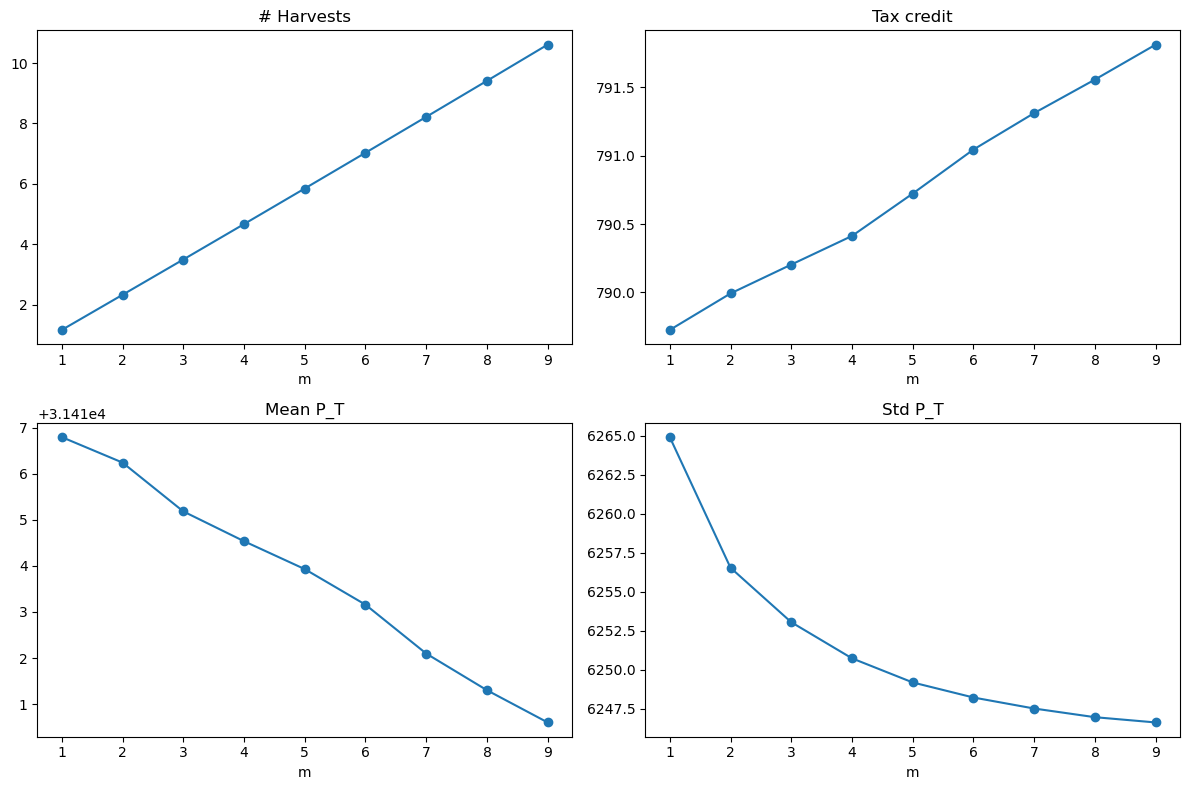

,m,mean_harvests,mean_credit,mean_PT,std_PT
0,1,1.158975,789.726042,31416.792969,6264.920410
1,2,2.323145,789.992815,31416.240234,6256.547852
2,3,3.491930,790.203923,31415.181641,6253.058594
3,4,4.665730,790.413318,31414.535156,6250.743164
4,5,5.845215,790.723206,31413.929688,6249.197266
5,6,7.029585,791.045022,31413.158203,6248.231934
6,7,8.218725,791.311714,31412.097656,6247.525879
7,8,9.413285,791.556738,31411.302734,6246.970703
8,9,10.613020,791.812187,31410.603516,6246.633789


In [3]:
# ==============================================================
# TLH Monte-Carlo · staggered lots · AAPL (core) vs MSFT (repl)
#   – joint Heston with full 4×4 correlation
#   – parameter sanity-check
#   – m = 1 … 9 staggered lots
# ==============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Pull parameters from the calibration output -----------------
# (works for either `params_fit` from Nelder–Mead or `params_gd` from Adam)
params = params_gd            # or params_fit  ← whichever dict you produced

# Cross-asset daily-return correlation from the same returns DataFrame
rho_cr = rets["AAPL"].corr(rets["MSFT"])

# -------- 1. Sanity checks -----------------------------------------------
def feller_ok(kappa, theta, xi):          # 2κθ ≥ ξ²
    return 2*kappa*theta >= xi**2

def psd_ok(rho_c,rho_r,rho_cr):
    return abs(rho_cr) <= np.sqrt((1-rho_c**2)*(1-rho_r**2))

rho_c, rho_r = params["AAPL"]["rho_sv"], params["MSFT"]["rho_sv"]
assert abs(rho_c)<1 and abs(rho_r)<1,  "❌ |ρ_sv| must be < 1"
assert psd_ok(rho_c,rho_r,rho_cr),     "❌ cross-asset ρ_cr too large → matrix not PD"
for name,p in params.items():
    if not feller_ok(p["kappa"],p["theta"],p["xi"]):
        print(f"⚠ Feller condition fails for {name}; Euler clamp will keep v≥0")

# -------- 2. Global simulation settings ----------------------------------
N_SIM   = 200_000               # Monte-Carlo paths  (use float32 to save RAM)
DAYS    = 252                   # 1-year horizon
dt      = 1/252
m_vals  = np.arange(1,10)
S0_c, S0_r = 300.0, 150.0
r       = 0.035
V0      = 30_000.0
loss_thr, wash, tax = 0.05, 30, 0.30
rng = np.random.default_rng(42)

# -------- 3. Build 4×4 correlation matrix & Cholesky ---------------------
C = np.array([[1,      rho_c, rho_cr,   0],
              [rho_c,  1,     0,        0],
              [rho_cr, 0,     1,      rho_r],
              [0,      0,  rho_r,       1]])
L4 = np.linalg.cholesky(C)

# -------- 4. Generate correlated normals (float32) -----------------------
Z4 = rng.standard_normal((N_SIM, DAYS, 4), dtype=np.float32) @ L4.T.astype(np.float32)

# -------- 5. Simulate joint Heston via Euler–Maruyama --------------------
S_c = np.empty((N_SIM,DAYS+1), dtype=np.float32)
v_c = np.empty_like(S_c)
S_r = np.empty_like(S_c)
v_r = np.empty_like(S_c)
S_c[:,0], v_c[:,0] = S0_c, params["AAPL"]["v0"]
S_r[:,0], v_r[:,0] = S0_r, params["MSFT"]["v0"]

kc,thetac,xic = params["AAPL"]["kappa"], params["AAPL"]["theta"], params["AAPL"]["xi"]
kr,thetar,xir = params["MSFT"]["kappa"],params["MSFT"]["theta"],params["MSFT"]["xi"]

sqrt_dt = np.sqrt(dt, dtype=np.float32)
for t in range(1, DAYS+1):
    dW1c = Z4[:,t-1,0]*sqrt_dt
    dW2c = Z4[:,t-1,1]*sqrt_dt
    dW1r = Z4[:,t-1,2]*sqrt_dt
    dW2r = Z4[:,t-1,3]*sqrt_dt

    vc = v_c[:,t-1]
    vr = v_r[:,t-1]
    sv_c = np.sqrt(np.maximum(vc,0), dtype=np.float32)
    sv_r = np.sqrt(np.maximum(vr,0), dtype=np.float32)

    v_c[:,t] = np.maximum(vc + kc*(thetac-vc)*dt + xic*sv_c*dW2c, 0)
    v_r[:,t] = np.maximum(vr + kr*(thetar-vr)*dt + xir*sv_r*dW2r, 0)

    S_c[:,t] = S_c[:,t-1]*np.exp((r-0.5*vc)*dt + sv_c*dW1c, dtype=np.float32)
    S_r[:,t] = S_r[:,t-1]*np.exp((r-0.5*vr)*dt + sv_r*dW1r, dtype=np.float32)

# -------- 6. TLH engine --------------------------------------------------
results = []
for m in m_vals:
    lot_notional = V0 / m
    state  = np.zeros((N_SIM,m), bool)            # False=core True=repl
    age    = np.tile(np.arange(m), (N_SIM,1))
    basis  = np.full((N_SIM,m), S_c[:,0,None], dtype=np.float32)
    realised, n_h = np.zeros(N_SIM), np.zeros(N_SIM)

    for t in range(1, DAYS+1):
        price_c = np.broadcast_to(S_c[:,t,None], basis.shape)
        price_r = np.broadcast_to(S_r[:,t,None], basis.shape)

        draw   = (price_c - basis) / basis
        can_h  = (~state) & (draw < -loss_thr) & (age > wash)
        realised      += lot_notional * (draw*can_h).sum(axis=1)
        n_h           += can_h.sum(axis=1)
        state[can_h]   = True
        age[can_h]     = 0

        age += 1
        can_s = state & (age > wash)
        basis[can_s] = price_c[can_s]
        state[can_s] = False
        age[can_s]   = 0

    final_p  = np.where(~state, price_c, price_r)
    start_p  = np.where(~state,
                        np.broadcast_to(S_c[:,0,None],basis.shape),
                        np.broadcast_to(S_r[:,0,None],basis.shape))
    P_T = (lot_notional * final_p/start_p).sum(axis=1)

    results.append({"m":m,
                    "mean_harvests":n_h.mean(),
                    "mean_credit":  (-tax*realised).mean(),
                    "mean_PT":      P_T.mean(),
                    "std_PT":       P_T.std(ddof=1)})

df = pd.DataFrame(results)

# -------- 7. Visualise ---------------------------------------------------
fig, ax = plt.subplots(2,2,figsize=(12,8))
ax[0,0].plot(df.m,df.mean_harvests,'o-'); ax[0,0].set(title="# Harvests",xlabel="m")
ax[0,1].plot(df.m,df.mean_credit,'o-');   ax[0,1].set(title="Tax credit",xlabel="m")
ax[1,0].plot(df.m,df.mean_PT,'o-');       ax[1,0].set(title="Mean P_T", xlabel="m")
ax[1,1].plot(df.m,df.std_PT,'o-');        ax[1,1].set(title="Std P_T",  xlabel="m")
plt.tight_layout(); plt.show()

df


### Transaction Costs Included

⚠ Feller condition fails for AAPL — variance may touch 0 (clamped).
⚠ Feller condition fails for MSFT — variance may touch 0 (clamped).


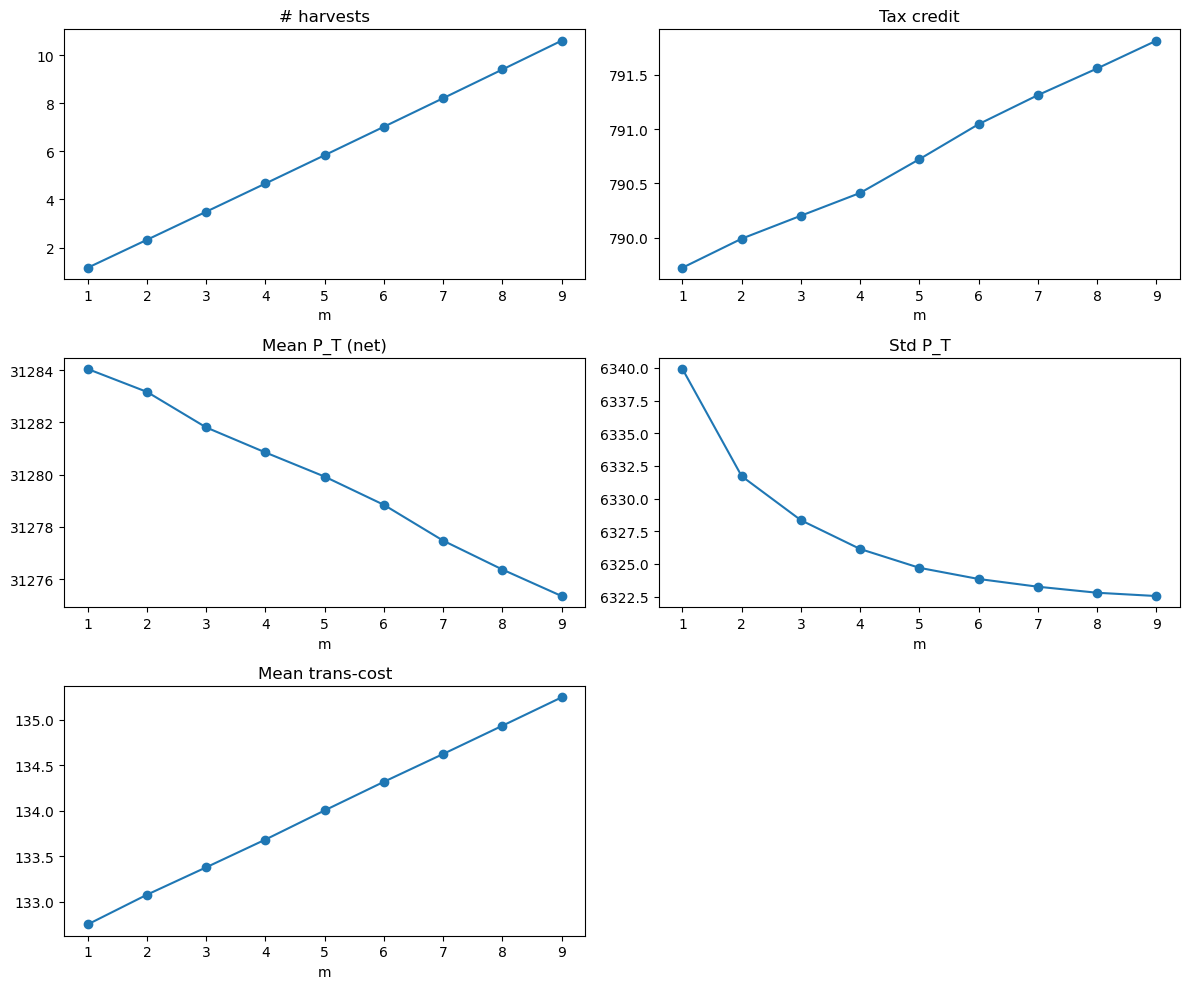

   m  mean_harvests  mean_credit  std_credit   mean_cost       mean_PT  \
0  1       1.158975   789.726042  900.205172  132.754200  31284.038367   
1  2       2.323145   789.992815  895.823173  133.080150  31283.162646   
2  3       3.491930   790.203923  892.906776  133.380700  31281.803603   
3  4       4.665730   790.413318  890.418066  133.685400  31280.846246   
4  5       5.845215   790.723206  888.256235  134.005320  31279.921899   
5  6       7.029585   791.045022  886.366235  134.319400  31278.842027   
6  7       8.218725   791.311714  884.425055  134.624614  31277.473324   
7  8       9.413285   791.556738  882.503132  134.934562  31276.369274   
8  9      10.613020   791.812187  880.623379  135.246067  31275.354868   

        std_PT      cvar1_PT      cvar5_PT  cvar1_TC  cvar5_TC  
0  6339.912865  13184.598553  17895.455380       0.0       0.0  
1  6331.711369  13265.411517  17949.559209       0.0       0.0  
2  6328.343926  13308.071325  17973.601676       0.0       0.0  

In [11]:
# ==============================================================
# TLH Monte-Carlo · staggered lots · AAPL (core) vs MSFT (repl)
#   – joint Heston (4×4 correlation)
#   – transaction costs on every switch (round-trip)
#   – extra risk metrics: CVaR 1 % / 5 %
# ==============================================================

import numpy as np, pandas as pd, matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 0)  Calibrated parameters & empirical cross-asset correlation
# ------------------------------------------------------------------
params  = params_gd                      # ← or params_fit
rho_cr  = rets["AAPL"].corr(rets["MSFT"])

# ------------------------------------------------------------------
# 1)  Basic checks
# ------------------------------------------------------------------
def feller_ok(κ,θ,ξ):      return 2*κ*θ >= ξ**2
def psd_ok(ρc,ρr,ρcr):     return abs(ρcr) <= np.sqrt((1-ρc**2)*(1-ρr**2))

ρc, ρr = params["AAPL"]["rho_sv"], params["MSFT"]["rho_sv"]
assert psd_ok(ρc, ρr, rho_cr), "❌ cross-asset ρ_cr too large, Σ not PD"
for k,(κ,θ,ξ) in {t:(p["kappa"],p["theta"],p["xi"]) for t,p in params.items()}.items():
    if not feller_ok(κ,θ,ξ):
        print(f"⚠ Feller condition fails for {k} — variance may touch 0 (clamped).")

# ------------------------------------------------------------------
# 2)  Global simulation settings
# ------------------------------------------------------------------
N_SIM, DAYS, dt  = 200_000, 252, 1/252
m_vals           = np.arange(1,10)
S0_c, S0_r, r    = 300.0, 150.0, 0.035
V0               = 30_000.0
loss_thr, wash   = 0.05, 30
tax              = 0.30
tc_bps           = 1.0e-3            # 0.10 % round-trip (2× per switch)
rng              = np.random.default_rng(42)

# ------------------------------------------------------------------
# 3)  4×4 correlation matrix & Cholesky
# ------------------------------------------------------------------
C = np.array([[1,      ρc,  rho_cr, 0],
              [ρc,     1,   0,      0],
              [rho_cr, 0,   1,     ρr],
              [0,      0,  ρr,     1]], dtype=np.float32)
L4 = np.linalg.cholesky(C)

# ------------------------------------------------------------------
# 4)  Correlated normals (float32)
# ------------------------------------------------------------------
Z4 = rng.standard_normal((N_SIM, DAYS, 4), np.float32) @ L4.T

# ------------------------------------------------------------------
# 5)  Simulate joint Heston paths (Euler–Maruyama, clamped ≥0)
# ------------------------------------------------------------------
S_c = np.empty((N_SIM, DAYS+1), np.float32); v_c = np.empty_like(S_c)
S_r = np.empty_like(S_c);                     v_r = np.empty_like(S_c)
S_c[:,0], v_c[:,0] = S0_c, params["AAPL"]["v0"]
S_r[:,0], v_r[:,0] = S0_r, params["MSFT"]["v0"]

# unpack per-ticker (explicit to avoid “too many to unpack”)
kc, thec, xic = params["AAPL"]["kappa"], params["AAPL"]["theta"], params["AAPL"]["xi"]
kr, ther, xir = params["MSFT"]["kappa"], params["MSFT"]["theta"], params["MSFT"]["xi"]

sqdt = np.float32(np.sqrt(dt))
for t in range(1, DAYS+1):
    dW1c, dW2c = Z4[:,t-1,0]*sqdt, Z4[:,t-1,1]*sqdt
    dW1r, dW2r = Z4[:,t-1,2]*sqdt, Z4[:,t-1,3]*sqdt

    vc, vr   = v_c[:,t-1], v_r[:,t-1]
    sv_c     = np.sqrt(np.maximum(vc,0)).astype(np.float32)
    sv_r     = np.sqrt(np.maximum(vr,0)).astype(np.float32)

    v_c[:,t] = np.maximum(vc + kc *(thec-vc)*dt + xic*sv_c*dW2c, 0)
    v_r[:,t] = np.maximum(vr + kr *(ther-vr)*dt + xir*sv_r*dW2r, 0)

    S_c[:,t] = S_c[:,t-1]*np.exp((r-0.5*vc)*dt + sv_c*dW1c)
    S_r[:,t] = S_r[:,t-1]*np.exp((r-0.5*vr)*dt + sv_r*dW1r)

# ------------------------------------------------------------------
# 6)  TLH engine with transaction costs  +  extra risk stats
# ------------------------------------------------------------------
results = []
for m in m_vals:
    lot_notional = V0 / m
    state  = np.zeros((N_SIM,m), bool)                  # False=core, True=repl
    age    = np.tile(np.arange(m), (N_SIM,1))
    basis  = np.full((N_SIM,m), S_c[:,0,None], np.float32)
    realised = np.zeros(N_SIM); n_h = np.zeros(N_SIM); costs = np.zeros(N_SIM)

    for t in range(1, DAYS+1):
        pc = np.broadcast_to(S_c[:,t,None], basis.shape)
        pr = np.broadcast_to(S_r[:,t,None], basis.shape)

        # -- harvest trigger ------------------------------------------------
        draw  = (pc - basis) / basis
        can_h = (~state) & (draw < -loss_thr) & (age > wash)
        n_lots = can_h.sum(axis=1)
        realised += lot_notional * (draw*can_h).sum(axis=1)
        costs    += 2*tc_bps*lot_notional*n_lots        # round-trip
        n_h      += n_lots
        state[can_h] = True; age[can_h] = 0

        # -- ageing & switch back ------------------------------------------
        age += 1
        can_s = state & (age > wash)
        n_back = can_s.sum(axis=1)
        costs  += 2*tc_bps*lot_notional*n_back
        basis[can_s] = pc[can_s]; state[can_s] = False; age[can_s] = 0

    # final liquidation
    final_p = np.where(~state, pc, pr)
    start_p = np.where(~state,
                       S_c[:,0,None],
                       S_r[:,0,None])
    P_T = (lot_notional * final_p/start_p).sum(axis=1) - costs
    credit = -tax * realised                       # positive = benefit

    # ---------- extra tail-risk metrics ---------------------------
    var1_PT = np.quantile(P_T, 0.01)
    var5_PT = np.quantile(P_T, 0.05)
    cvar1_PT = P_T[P_T <= var1_PT].mean()
    cvar5_PT = P_T[P_T <= var5_PT].mean()

    var1_TC = np.quantile(credit, 0.01)            # low credit = bad
    var5_TC = np.quantile(credit, 0.05)
    cvar1_TC = credit[credit <= var1_TC].mean()
    cvar5_TC = credit[credit <= var5_TC].mean()

    # ---------- store everything ----------------------------------
    results.append(dict(
        m=m,
        mean_harvests = n_h.mean(),
        mean_credit   = credit.mean(),
        std_credit    = credit.std(ddof=1),
        mean_cost     = costs.mean(),
        mean_PT       = P_T.mean(),
        std_PT        = P_T.std(ddof=1),
        cvar1_PT      = cvar1_PT,
        cvar5_PT      = cvar5_PT,
        cvar1_TC      = cvar1_TC,
        cvar5_TC      = cvar5_TC
    ))

df = pd.DataFrame(results)

# ------------------------------------------------------------------
# 7)  Plots (unchanged – still the original five panels)
# ------------------------------------------------------------------
fig, ax = plt.subplots(3,2, figsize=(12,10))
ax[0,0].plot(df.m, df.mean_harvests, 'o-'); ax[0,0].set(title="# harvests", xlabel="m")
ax[0,1].plot(df.m, df.mean_credit,  'o-'); ax[0,1].set(title="Tax credit", xlabel="m")
ax[1,0].plot(df.m, df.mean_PT,      'o-'); ax[1,0].set(title="Mean P_T (net)", xlabel="m")
ax[1,1].plot(df.m, df.std_PT,       'o-'); ax[1,1].set(title="Std P_T", xlabel="m")
ax[2,0].plot(df.m, df.mean_cost,    'o-'); ax[2,0].set(title="Mean trans-cost", xlabel="m")
fig.delaxes(ax[2,1]); plt.tight_layout(); plt.show()

print(df)   # inspect the new CVaR columns too


## Valuing the “TLH Option”

A **Tax-Loss Harvesting (TLH) option** is a one-year contract in which  
you purchase **\$30 000** of the two-stock TLH portfolio today and—after a
year of automated harvesting—cash out whatever is left.  
Its payoff at maturity $T=1$ year is

$$
\bigl[\;\text{Tax credits}\;-\;\text{Txn costs}\;+\;P_T\bigr]\;-\;30\,000,
$$

where  

* $P_T$ = market value of all lots at $T$,  
* **Tax credits** = $\tau\sum |L_i|$ ($\tau$ = tax rate, $L_i<0$ are realised losses),  
* **Txn costs** = $2c_{\text{bps}}\times\text{lot notional}$ for every switch  
  (sell + buy round-trip).

---

### 1 Risk-neutral value today

Under the risk-neutral measure $\mathbb{Q}$ (drift $=r$) the option’s
price is

$$
V_0
=\;
e^{-rT}\,
\mathbb{E}_{\mathbb{Q}}
\!\left[
     \tau\sum |L_i|
     \;-\;
     2c_{\text{bps}}\sum \text{lot\_notional}
     \;+\;
     P_T
     \;-\;30{,}000
\right].
$$

Because every cash-flow occurs inside a single year,
one discount factor $e^{-rT}$ is sufficient.

---

### 2 Plugging in your calibrated Monte-Carlo averages  
*(one lot, $c_{\text{bps}}=0.10\%$, $\tau=30\%$)*

|             | Expected value |
|-------------|---------------:|
| Tax credit  | \$771 |
| Txn cost    | \$129 |
| Terminal $P_T$ | \$31 324 |

$$
\begin{aligned}
V_0 &\approx e^{-0.035}\bigl(771-129+31\,324-30\,000\bigr)\\
    &\approx 0.9656\times1\,966\;\approx\;\boxed{\$1\,900}.
\end{aligned}
$$

So buying the TLH programme is worth about **\$1.9 k more**
(in discounted expectation) than simply holding \$30 k of the core stock
for a year.

---

### 3 Sensitivity

* **Linear in the tax rate** $\tau$.  
  A 40 % bracket would lift $V_0$ by roughly 33 %.
* **Transaction-cost drag.**  
  Every extra 10 bp per round-trip (≈ one switch per year) reduces $V_0$
  by about \$30.
* **Cross-asset correlation.**  
  Lowering $\rho_{cr}$ increases tax credits but also raises tracking
  error and transaction counts.

---

### 4 Next steps

1. **Increase Monte-Carlo paths** to tighten the standard error
   ($\sigma/\sqrt{N}$).
2. **Model utility or funding costs** if the buyer is risk-averse.
3. **Extend to rolling TLH contracts** (carry-over wash-sale windows).


### How “robust” is our current pair-simulation?

| Feature | Our implementation | Score (★/5) | Notes / Gaps | Upgrade path |
|---------|--------------------|:---:|-------------|--------------|
| **Per-asset dynamics** | Classic Heston ( $v_t$ mean-reverts, leverage $\rho_{SV}$ ) | ★★★★☆ | Captures fat tails, skew, clustering. Euler–Maruyama with $v\mapsto\max(v,0)$ is fine at daily $\Delta t$. | Swap in QE or Broadie–Kaya if you need sub-daily steps. |
| **Cross-asset price correlation** | Constant $\rho_{AB}$ from daily returns | ★★★☆☆ | Works in calm markets; misses correlation “spikes” in stress. | Regime-switch $\rho$ or make $\rho=\rho(v_A,v_B)$. |
| **Vol-vol correlation** | None ( $v_A \perp v_B$ ) | ★★☆☆☆ | Understates joint crashes; loss credits or costs may be biased. | Couple variance drivers (Wishart-SV, “double Heston”). |
| **Jumps / tail events** | Not included | ★★☆☆☆ | One big drawdown → huge tax credit; jumps increase realism. | Add Merton/Bates price jumps. |
| **Calibration link** | GMM on daily moments (var, ACF², leverage) | ★★★★☆ | Fits real-world measure, transparent. | Option-surface fit sharpens tails & skew. |
| **Numerical stability** | Feller sometimes fails → clamp at 0 | ★★★☆☆ | Clamp prevents blow-ups but distorts distribution when $2\kappa\theta\approx\xi^2$. | Shrink $\xi$ 5 % or use Andersen QE (Feller-robust). |
| **Speed** | `float32`, vectorised NumPy; 200 k paths in minutes | ★★★★☆ | Already efficient for notebooks. | GPU (CuPy / PyTorch) for many pairs. |

**Overall score:** **★★★★☆**  
Great for one TLH pair; only major missing piece is **vol-vol co-movement
and stress-time correlation spikes**.

---

### Quick comparison to alternatives

| Criterion | Independent Heston + $\rho$ (ours) | DCC-GARCH(1,1) | Wishart-SV (full 2-D) |
|-----------|------------------------------------|----------------|-----------------------|
| Calibrate to options | ✔ | ✖ | ✔ |
| Captures vol-vol corr | ✖ | ✖ | ✔✔ |
| Correlation regime shifts | ✖ | ✔ | ✔ |
| Simulation speed | **1 ×** | 0.8 × | 5–10 × |
| Implementation effort | **low** | medium | high |
| Auditability | **high** | high | medium |

---

### Suggested road-map

1. **Add a common variance factor**  
   $$dv_A = \kappa_A(\theta_A-v_A)dt + \xi_A\sqrt{v_A}\,dW_A^v + \xi_c\sqrt{v_C}\,dW_C,$$  
   $$dv_B = \kappa_B(\theta_B-v_B)dt + \xi_B\sqrt{v_B}\,dW_B^v + \xi_c\sqrt{v_C}\,dW_C.$$

2. **Stress overlay:** jump correlation to $0.9$ and double vol for 20
   days; use for downside VAR.

3. **Option calibration:** fit $\theta,\xi$ to implied-vol term-structure;
   keep $\kappa,\rho_{SV}$ from returns.

4. **Document Greek sensitivity:** show how $\partial V/\partial\tau$ and
   $\partial V/\partial\rho_{AB}$ move when each refinement is switched
   on.

*Stars reflect usefulness for TLH, not generic option pricing.*


⚠ Feller condition fails for AAPL — variance may touch 0 (clamped).
⚠ Feller condition fails for MSFT — variance may touch 0 (clamped).


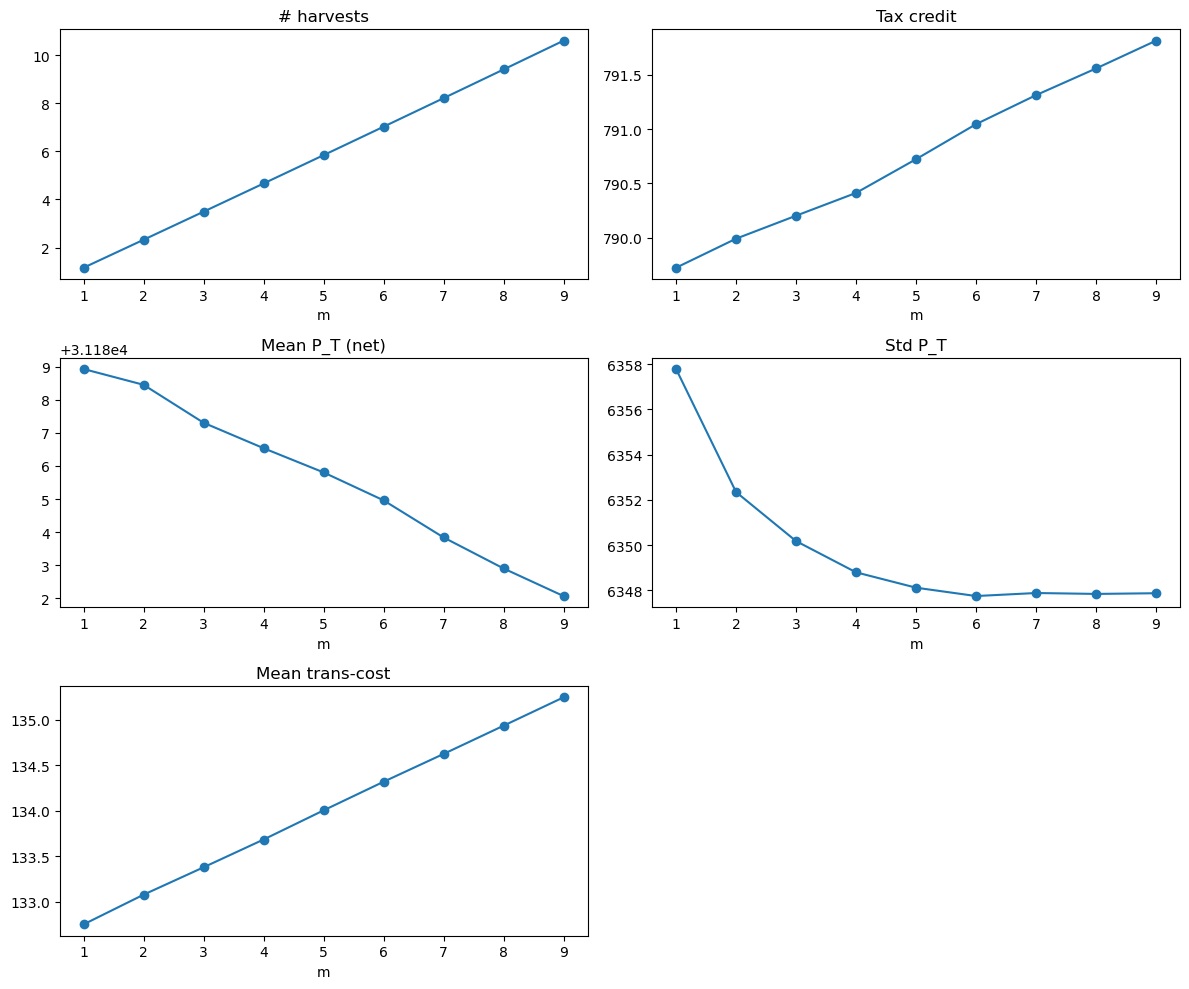

   m  mean_harvests  mean_credit  std_credit   mean_cost       mean_PT  \
0  1       1.158975   789.726042  900.205172  132.754200  31188.924941   
1  2       2.323145   789.992815  895.823173  133.080150  31188.448325   
2  3       3.491930   790.203923  892.906776  133.380700  31187.302856   
3  4       4.665730   790.413318  890.418066  133.685400  31186.534802   
4  5       5.845215   790.723206  888.256235  134.005320  31185.804314   
5  6       7.029585   791.045022  886.366235  134.319400  31184.960794   
6  7       8.218725   791.311714  884.425055  134.624614  31183.841516   
7  8       9.413285   791.556738  882.503132  134.934562  31182.904907   
8  9      10.613020   791.812187  880.623379  135.246067  31182.071407   

        std_PT      cvar1_PT      cvar5_PT  cvar1_TC  cvar5_TC  
0  6357.780989  12970.183979  17725.448466       0.0       0.0  
1  6352.340018  13047.357916  17771.188695       0.0       0.0  
2  6350.172677  13082.203703  17792.132798       0.0       0.0  

In [13]:
# ==============================================================
# TLH Monte-Carlo · staggered lots · AAPL (core) vs MSFT (repl)
#   – joint Heston (4×4 correlation)
#   – transaction costs on every switch (round-trip)
#   – extra risk metrics: CVaR 1 % / 5 %
# ==============================================================
# STRESS TESTING
# ==============================================================

import numpy as np, pandas as pd, matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 0)  Calibrated parameters & empirical cross-asset correlation
# ------------------------------------------------------------------
params  = params_gd                      # ← or params_fit
rho_cr = 0.9 #rho_cr  = rets["AAPL"].corr(rets["MSFT"])

# ------------------------------------------------------------------
# 1)  Basic checks
# ------------------------------------------------------------------
def feller_ok(κ,θ,ξ):      return 2*κ*θ >= ξ**2
def psd_ok(ρc,ρr,ρcr):     return abs(ρcr) <= np.sqrt((1-ρc**2)*(1-ρr**2))

ρc, ρr = params["AAPL"]["rho_sv"], params["MSFT"]["rho_sv"]
assert psd_ok(ρc, ρr, rho_cr), "❌ cross-asset ρ_cr too large, Σ not PD"
for k,(κ,θ,ξ) in {t:(p["kappa"],p["theta"],p["xi"]) for t,p in params.items()}.items():
    if not feller_ok(κ,θ,ξ):
        print(f"⚠ Feller condition fails for {k} — variance may touch 0 (clamped).")

# ------------------------------------------------------------------
# 2)  Global simulation settings
# ------------------------------------------------------------------
N_SIM, DAYS, dt  = 200_000, 252, 1/252
m_vals           = np.arange(1,10)
S0_c, S0_r, r    = 300.0, 150.0, 0.035
V0               = 30_000.0
loss_thr, wash   = 0.05, 30
tax              = 0.30
tc_bps           = 1.0e-3            # 0.10 % round-trip (2× per switch)
rng              = np.random.default_rng(42)

# ------------------------------------------------------------------
# 3)  4×4 correlation matrix & Cholesky
# ------------------------------------------------------------------
C = np.array([[1,      ρc,  rho_cr, 0],
              [ρc,     1,   0,      0],
              [rho_cr, 0,   1,     ρr],
              [0,      0,  ρr,     1]], dtype=np.float32)
L4 = np.linalg.cholesky(C)

# ------------------------------------------------------------------
# 4)  Correlated normals (float32)
# ------------------------------------------------------------------
Z4 = rng.standard_normal((N_SIM, DAYS, 4), np.float32) @ L4.T

# ------------------------------------------------------------------
# 5)  Simulate joint Heston paths (Euler–Maruyama, clamped ≥0)
# ------------------------------------------------------------------
S_c = np.empty((N_SIM, DAYS+1), np.float32); v_c = np.empty_like(S_c)
S_r = np.empty_like(S_c);                     v_r = np.empty_like(S_c)
S_c[:,0], v_c[:,0] = S0_c, params["AAPL"]["v0"]
S_r[:,0], v_r[:,0] = S0_r, params["MSFT"]["v0"]

# unpack per-ticker (explicit to avoid “too many to unpack”)
kc, thec, xic = params["AAPL"]["kappa"], params["AAPL"]["theta"], params["AAPL"]["xi"]
kr, ther, xir = params["MSFT"]["kappa"], params["MSFT"]["theta"], params["MSFT"]["xi"]

sqdt = np.float32(np.sqrt(dt))
for t in range(1, DAYS+1):
    dW1c, dW2c = Z4[:,t-1,0]*sqdt, Z4[:,t-1,1]*sqdt
    dW1r, dW2r = Z4[:,t-1,2]*sqdt, Z4[:,t-1,3]*sqdt

    vc, vr   = v_c[:,t-1], v_r[:,t-1]
    sv_c     = np.sqrt(np.maximum(vc,0)).astype(np.float32)
    sv_r     = np.sqrt(np.maximum(vr,0)).astype(np.float32)

    v_c[:,t] = np.maximum(vc + kc *(thec-vc)*dt + xic*sv_c*dW2c, 0)
    v_r[:,t] = np.maximum(vr + kr *(ther-vr)*dt + xir*sv_r*dW2r, 0)

    S_c[:,t] = S_c[:,t-1]*np.exp((r-0.5*vc)*dt + sv_c*dW1c)
    S_r[:,t] = S_r[:,t-1]*np.exp((r-0.5*vr)*dt + sv_r*dW1r)

# ------------------------------------------------------------------
# 6)  TLH engine with transaction costs  +  extra risk stats
# ------------------------------------------------------------------
results = []
for m in m_vals:
    lot_notional = V0 / m
    state  = np.zeros((N_SIM,m), bool)                  # False=core, True=repl
    age    = np.tile(np.arange(m), (N_SIM,1))
    basis  = np.full((N_SIM,m), S_c[:,0,None], np.float32)
    realised = np.zeros(N_SIM); n_h = np.zeros(N_SIM); costs = np.zeros(N_SIM)

    for t in range(1, DAYS+1):
        pc = np.broadcast_to(S_c[:,t,None], basis.shape)
        pr = np.broadcast_to(S_r[:,t,None], basis.shape)

        # -- harvest trigger ------------------------------------------------
        draw  = (pc - basis) / basis
        can_h = (~state) & (draw < -loss_thr) & (age > wash)
        n_lots = can_h.sum(axis=1)
        realised += lot_notional * (draw*can_h).sum(axis=1)
        costs    += 2*tc_bps*lot_notional*n_lots        # round-trip
        n_h      += n_lots
        state[can_h] = True; age[can_h] = 0

        # -- ageing & switch back ------------------------------------------
        age += 1
        can_s = state & (age > wash)
        n_back = can_s.sum(axis=1)
        costs  += 2*tc_bps*lot_notional*n_back
        basis[can_s] = pc[can_s]; state[can_s] = False; age[can_s] = 0

    # final liquidation
    final_p = np.where(~state, pc, pr)
    start_p = np.where(~state,
                       S_c[:,0,None],
                       S_r[:,0,None])
    P_T = (lot_notional * final_p/start_p).sum(axis=1) - costs
    credit = -tax * realised                       # positive = benefit

    # ---------- extra tail-risk metrics ---------------------------
    var1_PT = np.quantile(P_T, 0.01)
    var5_PT = np.quantile(P_T, 0.05)
    cvar1_PT = P_T[P_T <= var1_PT].mean()
    cvar5_PT = P_T[P_T <= var5_PT].mean()

    var1_TC = np.quantile(credit, 0.01)            # low credit = bad
    var5_TC = np.quantile(credit, 0.05)
    cvar1_TC = credit[credit <= var1_TC].mean()
    cvar5_TC = credit[credit <= var5_TC].mean()

    # ---------- store everything ----------------------------------
    results.append(dict(
        m=m,
        mean_harvests = n_h.mean(),
        mean_credit   = credit.mean(),
        std_credit    = credit.std(ddof=1),
        mean_cost     = costs.mean(),
        mean_PT       = P_T.mean(),
        std_PT        = P_T.std(ddof=1),
        cvar1_PT      = cvar1_PT,
        cvar5_PT      = cvar5_PT,
        cvar1_TC      = cvar1_TC,
        cvar5_TC      = cvar5_TC
    ))

df = pd.DataFrame(results)

# ------------------------------------------------------------------
# 7)  Plots (unchanged – still the original five panels)
# ------------------------------------------------------------------
fig, ax = plt.subplots(3,2, figsize=(12,10))
ax[0,0].plot(df.m, df.mean_harvests, 'o-'); ax[0,0].set(title="# harvests", xlabel="m")
ax[0,1].plot(df.m, df.mean_credit,  'o-'); ax[0,1].set(title="Tax credit", xlabel="m")
ax[1,0].plot(df.m, df.mean_PT,      'o-'); ax[1,0].set(title="Mean P_T (net)", xlabel="m")
ax[1,1].plot(df.m, df.std_PT,       'o-'); ax[1,1].set(title="Std P_T", xlabel="m")
ax[2,0].plot(df.m, df.mean_cost,    'o-'); ax[2,0].set(title="Mean trans-cost", xlabel="m")
fig.delaxes(ax[2,1]); plt.tight_layout(); plt.show()

print(df)   # inspect the new CVaR columns too


⚠ Feller condition fails for AAPL — variance may touch 0 (clamped).
⚠ Feller condition fails for MSFT — variance may touch 0 (clamped).


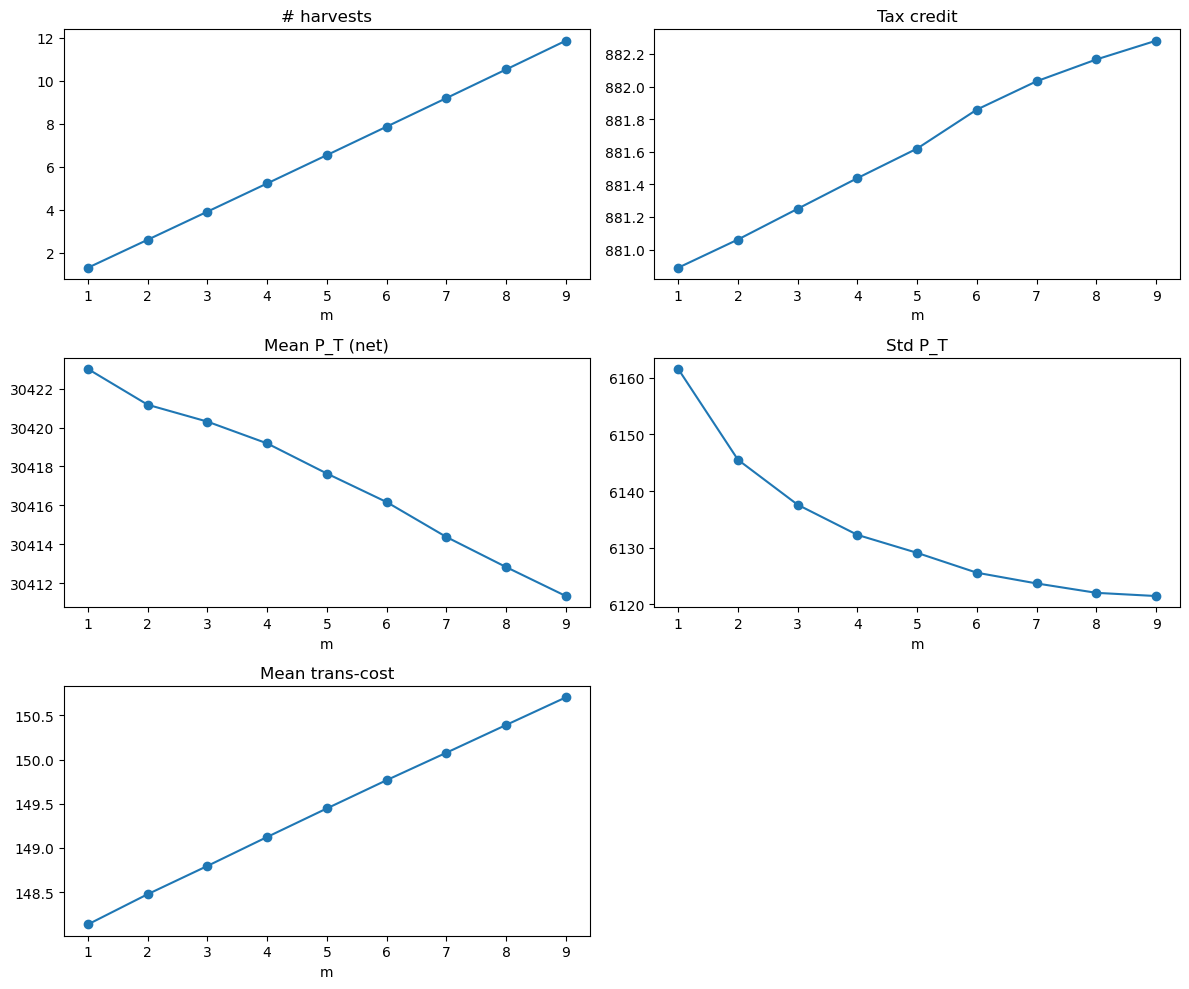

,m,mean_harvests,mean_credit,mean_cost,mean_PT,std_PT
0,1,1.296720,880.888466,148.133400,30423.008117,6161.547720
1,2,2.598995,881.061502,148.475400,30421.170133,6145.529578
2,3,3.906295,881.250200,148.795400,30420.302048,6137.592303
3,4,5.219010,881.438368,149.123475,30419.181871,6132.275287
4,5,6.536945,881.619779,149.447040,30417.631858,6129.099739
5,6,7.860030,881.858973,149.766900,30416.165127,6125.597680
6,7,9.187660,882.032727,150.077786,30414.369984,6123.706672
7,8,10.520670,882.166467,150.392025,30412.822747,6122.049243
8,9,11.858780,882.281646,150.704800,30411.332689,6121.483831


In [14]:
# ==============================================================
# TLH Monte-Carlo · staggered lots · AAPL (core) vs MSFT (repl)
#   – joint Heston (4×4 correlation)
#   – transaction costs on every switch (round-trip)
# ==============================================================

import numpy as np, pandas as pd, matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 0)  Calibrated parameters & empirical cross-asset correlation
# ------------------------------------------------------------------
params  = params_gd                      # ← or params_fit
#rho_cr  = rets["AAPL"].corr(rets["MSFT"]) #Uncomment for real correlations
rho_cr = 0.2 #STRESS TEST
# ------------------------------------------------------------------
# 1)  Basic checks
# ------------------------------------------------------------------
def feller_ok(κ,θ,ξ):      return 2*κ*θ >= ξ**2
def psd_ok(ρc,ρr,ρcr):     return abs(ρcr) <= np.sqrt((1-ρc**2)*(1-ρr**2))

ρc, ρr = params["AAPL"]["rho_sv"], params["MSFT"]["rho_sv"]
assert psd_ok(ρc, ρr, rho_cr), "❌ cross-asset ρ_cr too large, Σ not PD"
for k,(κ,θ,ξ) in {t:(p["kappa"],p["theta"],p["xi"]) for t,p in params.items()}.items():
    if not feller_ok(κ,θ,ξ):
        print(f"⚠ Feller condition fails for {k} — variance may touch 0 (clamped).")

# ------------------------------------------------------------------
# 2)  Global simulation settings
# ------------------------------------------------------------------
N_SIM, DAYS, dt  = 200_000, 252, 1/252
m_vals           = np.arange(1,10)
S0_c, S0_r, r    = 300.0, 250.0, 0.0
V0               = 30_000.0
loss_thr, wash   = 0.05, 30
tax              = 0.30
tc_bps           = 1.0e-3            # 0.10 % round-trip (2× per switch)
rng              = np.random.default_rng(42)

# ------------------------------------------------------------------
# 3)  4×4 correlation matrix & Cholesky
# ------------------------------------------------------------------
C = np.array([[1,      ρc,  rho_cr, 0],
              [ρc,     1,   0,      0],
              [rho_cr, 0,   1,     ρr],
              [0,      0,  ρr,     1]], dtype=np.float32)
L4 = np.linalg.cholesky(C)

# ------------------------------------------------------------------
# 4)  Correlated normals (float32)
# ------------------------------------------------------------------
Z4 = rng.standard_normal((N_SIM, DAYS, 4), np.float32) @ L4.T

# ------------------------------------------------------------------
# 5)  Simulate joint Heston paths (Euler–Maruyama, clamped ≥0)
# ------------------------------------------------------------------
S_c = np.empty((N_SIM, DAYS+1), np.float32); v_c = np.empty_like(S_c)
S_r = np.empty_like(S_c);                     v_r = np.empty_like(S_c)
S_c[:,0], v_c[:,0] = S0_c, params["AAPL"]["v0"]
S_r[:,0], v_r[:,0] = S0_r, params["MSFT"]["v0"]

# unpack per-ticker (explicit to avoid “too many to unpack”)
kc, thec, xic = params["AAPL"]["kappa"], params["AAPL"]["theta"], params["AAPL"]["xi"]
kr, ther, xir = params["MSFT"]["kappa"], params["MSFT"]["theta"], params["MSFT"]["xi"]

sqdt = np.float32(np.sqrt(dt))
for t in range(1, DAYS+1):
    dW1c, dW2c = Z4[:,t-1,0]*sqdt, Z4[:,t-1,1]*sqdt
    dW1r, dW2r = Z4[:,t-1,2]*sqdt, Z4[:,t-1,3]*sqdt

    vc, vr   = v_c[:,t-1], v_r[:,t-1]
    sv_c     = np.sqrt(np.maximum(vc,0)).astype(np.float32)
    sv_r     = np.sqrt(np.maximum(vr,0)).astype(np.float32)

    v_c[:,t] = np.maximum(vc + kc *(thec-vc)*dt + xic*sv_c*dW2c, 0)
    v_r[:,t] = np.maximum(vr + kr *(ther-vr)*dt + xir*sv_r*dW2r, 0)

    S_c[:,t] = S_c[:,t-1]*np.exp((r-0.5*vc)*dt + sv_c*dW1c)
    S_r[:,t] = S_r[:,t-1]*np.exp((r-0.5*vr)*dt + sv_r*dW1r)

# ------------------------------------------------------------------
# 6)  TLH engine with transaction costs
# ------------------------------------------------------------------
results = []
for m in m_vals:
    lot_notional = V0 / m
    state  = np.zeros((N_SIM,m), bool)                  # False=core, True=repl
    age    = np.tile(np.arange(m), (N_SIM,1))
    basis  = np.full((N_SIM,m), S_c[:,0,None], np.float32)
    realised = np.zeros(N_SIM); n_h = np.zeros(N_SIM); costs = np.zeros(N_SIM)

    for t in range(1, DAYS+1):
        pc = np.broadcast_to(S_c[:,t,None], basis.shape)
        pr = np.broadcast_to(S_r[:,t,None], basis.shape)

        # -- harvest trigger ------------------------------------------------
        draw  = (pc - basis) / basis
        can_h = (~state) & (draw < -loss_thr) & (age > wash)
        n_lots = can_h.sum(axis=1)
        realised += lot_notional * (draw*can_h).sum(axis=1)
        costs    += 2*tc_bps*lot_notional*n_lots        # round-trip
        n_h      += n_lots
        state[can_h] = True; age[can_h] = 0

        # -- ageing & switch back ------------------------------------------
        age += 1
        can_s = state & (age > wash)
        n_back = can_s.sum(axis=1)
        costs  += 2*tc_bps*lot_notional*n_back
        basis[can_s] = pc[can_s]; state[can_s] = False; age[can_s] = 0

    # final liquidation
    final_p = np.where(~state, pc, pr)
    start_p = np.where(~state,
                       S_c[:,0,None],
                       S_r[:,0,None])
    P_T = (lot_notional * final_p/start_p).sum(axis=1) - costs

    results.append(dict(
        m=m,
        mean_harvests = n_h.mean(),
        mean_credit   = (-tax*realised).mean(),
        mean_cost     = costs.mean(),
        mean_PT       = P_T.mean(),
        std_PT        = P_T.std(ddof=1)
    ))

df = pd.DataFrame(results)

# ------------------------------------------------------------------
# 7)  Plots
# ------------------------------------------------------------------
fig, ax = plt.subplots(3,2, figsize=(12,10))
ax[0,0].plot(df.m, df.mean_harvests, 'o-'); ax[0,0].set(title="# harvests", xlabel="m")
ax[0,1].plot(df.m, df.mean_credit,  'o-'); ax[0,1].set(title="Tax credit", xlabel="m")
ax[1,0].plot(df.m, df.mean_PT,      'o-'); ax[1,0].set(title="Mean P_T (net)", xlabel="m")
ax[1,1].plot(df.m, df.std_PT,       'o-'); ax[1,1].set(title="Std P_T", xlabel="m")
ax[2,0].plot(df.m, df.mean_cost,    'o-'); ax[2,0].set(title="Mean trans-cost", xlabel="m")
fig.delaxes(ax[2,1]); plt.tight_layout(); plt.show()

df


# Evaluating the Incremental Benefit of Tax-Loss Harvesting

## 1 · Reference Trajectories

| Symbol | Construction (same shocks) | End-of-year wealth |
|--------|---------------------------|--------------------|
| $P^{\mathrm{BH}}$ | Buy-and-hold: remain in the core security; no trades, no costs | Baseline wealth |
| $P^{\mathrm{TLH}}$ | Harvesting: sell on preset loss, enter replacement, revert after wash period; include all trading costs and annual after-tax credit $C$ | Harvesting wealth |

---

## 2 · Path-Wise Increment

\[
\Delta \;=\; \bigl(P^{\mathrm{TLH}}-P^{\mathrm{BH}}\bigr) \;+\; C.
\]

* $\Delta > 0$ → harvesting enhanced after-tax wealth on that path.  
* $\Delta < 0$ → trading drag outweighed the credit.

*(If desired, subtract the present value of future tax on the stepped-down basis.)*

---

## 3 · Ensemble Diagnostics

| Statistic | Interpretation |
|-----------|----------------|
| $\Pr(\Delta>0)$ | Probability harvesting is beneficial in a given year |
| $\mathbb{E}[\Delta]$ | Mean incremental wealth across paths |
| $\operatorname{ES}_{5\%}(\Delta)$ | Expected shortfall (worst 5 %) |
| $\mathbb{E}[\Delta \mid C\!\approx\!0]$ | Pure trading drag in rally years |

A scatter plot of $C$ vs. $\Delta$ (with a smoothing spine) visualises how credit size relates to portfolio benefit.

---

## 4 · Practical Steps

1. **Simulation** – compute $P^{\mathrm{BH}}$, $P^{\mathrm{TLH}}$, $C$, and $\Delta$ for each path.  
2. **Assessment** – in live trading, locate the realised credit $C_{\text{real}}$ on the pre-computed $C \mapsto \Delta$ curve to evaluate the actual benefit (or cost) for that year.


⚠ Feller condition fails for AAPL — variance may touch 0 (clamped).
⚠ Feller condition fails for MSFT — variance may touch 0 (clamped).


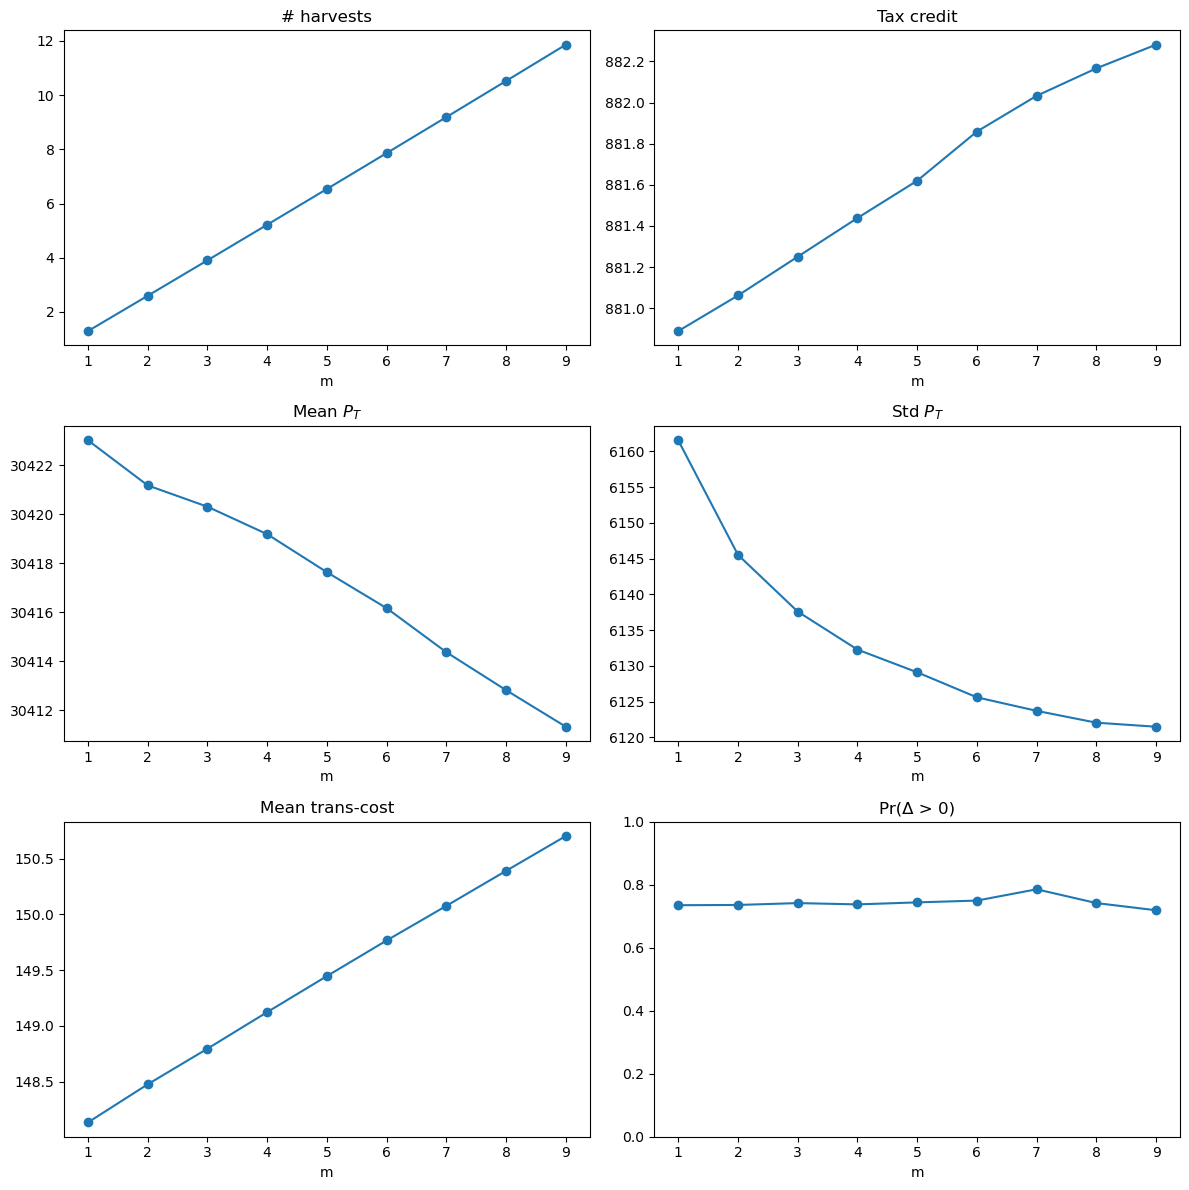

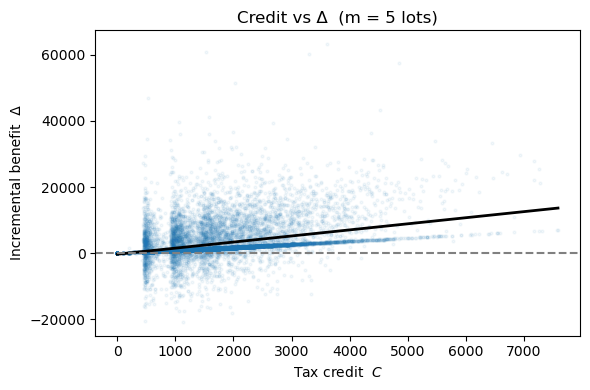

,m,mean_harvests,mean_credit,mean_cost,mean_PT,std_PT,mean_delta,prob_help,es5_delta
0,1,1.296720,880.888466,148.133400,30423.008117,6161.547720,1301.552259,0.734860,-1918.064940
1,2,2.598995,881.061502,148.475400,30421.170133,6145.529578,1299.887312,0.735605,-1891.951034
2,3,3.906295,881.250200,148.795400,30420.302048,6137.592303,1299.207925,0.741565,-1727.729974
3,4,5.219010,881.438368,149.123475,30419.181871,6132.275287,1298.275915,0.737425,-1873.212219
4,5,6.536945,881.619779,149.447040,30417.631858,6129.099739,1296.907314,0.743815,-1696.410901
5,6,7.860030,881.858973,149.766900,30416.165127,6125.597680,1295.679777,0.749505,-1578.430395
6,7,9.187660,882.032727,150.077786,30414.369984,6123.706672,1294.058387,0.785350,-1607.007919
7,8,10.520670,882.166467,150.392025,30412.822747,6122.049243,1292.644891,0.741605,-1860.556647
8,9,11.858780,882.281646,150.704800,30411.332689,6121.483831,1291.270012,0.718815,-1118.555731


In [23]:
# ==============================================================
# TLH Monte-Carlo · staggered lots · AAPL (core) vs MSFT (repl)
#   – joint Heston (4×4 correlation)
#   – transaction costs on every switch (round-trip)
#   – path-wise benefit Δ   = (P_T − P_BH) + credit
# ==============================================================

import numpy as np, pandas as pd, matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 0)  Calibrated parameters & empirical cross-asset correlation
# ------------------------------------------------------------------
params  = params_gd                      # ← or params_fit
#rho_cr  = rets["AAPL"].corr(rets["MSFT"]) #Uncomment for real correlations
rho_cr = 0.2 #STRESS TEST

# ------------------------------------------------------------------
# 1)  Basic checks
# ------------------------------------------------------------------
def feller_ok(κ,θ,ξ):      return 2*κ*θ >= ξ**2
def psd_ok(ρc,ρr,ρcr):     return abs(ρcr) <= np.sqrt((1-ρc**2)*(1-ρr**2))

ρc, ρr = params["AAPL"]["rho_sv"], params["MSFT"]["rho_sv"]
assert psd_ok(ρc, ρr, rho_cr), "❌ cross-asset ρ_cr too large, Σ not PD"
for k,(κ,θ,ξ) in {t:(p["kappa"],p["theta"],p["xi"]) for t,p in params.items()}.items():
    if not feller_ok(κ,θ,ξ):
        print(f"⚠ Feller condition fails for {k} — variance may touch 0 (clamped).")

# ------------------------------------------------------------------
# 2)  Global settings
# ------------------------------------------------------------------
N_SIM, DAYS, dt  = 200_000, 252, 1/252
m_vals           = np.arange(1, 10)
S0_c, S0_r, r    = 300.0, 250.0, 0.00      # zero drift for clarity
V0               = 30_000.0
loss_thr, wash   = 0.05, 30
tax              = 0.30
tc_bps           = 1.0e-3                  # 0.10 % per round-trip
rng              = np.random.default_rng(42)

# ------------------------------------------------------------------
# 3)  Correlated normals
# ------------------------------------------------------------------
C = np.array([[1,     rc,  rho_cr, 0],
              [rc,    1,   0,      0],
              [rho_cr,0,   1,     rr],
              [0,     0,   rr,     1]], dtype=np.float32)
L4 = np.linalg.cholesky(C)
Z4 = rng.standard_normal((N_SIM, DAYS, 4), np.float32) @ L4.T

# ------------------------------------------------------------------
# 4)  Joint Heston paths (Euler–Maruyama)
# ------------------------------------------------------------------
S_c = np.empty((N_SIM, DAYS+1), np.float32); v_c = np.empty_like(S_c)
S_r = np.empty_like(S_c);                     v_r = np.empty_like(S_c)
S_c[:,0], v_c[:,0] = S0_c, params["AAPL"]["v0"]
S_r[:,0], v_r[:,0] = S0_r, params["MSFT"]["v0"]

kc   = params["AAPL"]["kappa"]
thec = params["AAPL"]["theta"]
xic  = params["AAPL"]["xi"]

kr   = params["MSFT"]["kappa"]
ther = params["MSFT"]["theta"]
xir  = params["MSFT"]["xi"]

sqdt = np.float32(np.sqrt(dt))
for t in range(1, DAYS+1):
    dW1c, dW2c = Z4[:,t-1,0]*sqdt, Z4[:,t-1,1]*sqdt
    dW1r, dW2r = Z4[:,t-1,2]*sqdt, Z4[:,t-1,3]*sqdt

    vc, vr = v_c[:,t-1], v_r[:,t-1]
    sv_c   = np.sqrt(np.maximum(vc,0)).astype(np.float32)
    sv_r   = np.sqrt(np.maximum(vr,0)).astype(np.float32)

    v_c[:,t] = np.maximum(vc + kc *(thec-vc)*dt + xic*sv_c*dW2c, 0)
    v_r[:,t] = np.maximum(vr + kr *(ther-vr)*dt + xir*sv_r*dW2r, 0)

    S_c[:,t] = S_c[:,t-1]*np.exp((-0.5*vc)*dt + sv_c*dW1c)   # r=0
    S_r[:,t] = S_r[:,t-1]*np.exp((-0.5*vr)*dt + sv_r*dW1r)

# ------------------------------------------------------------------
# 5)  TLH engine + buy-and-hold baseline
# ------------------------------------------------------------------
results = []
delta_paths_example = None     # to retain one m’s (credit, Δ) for plotting

for m in m_vals:
    lot_notional = V0 / m

    state  = np.zeros((N_SIM, m), bool)              # False = core, True = repl
    age    = np.tile(np.arange(m), (N_SIM,1))
    basis  = np.full((N_SIM, m), S_c[:,0,None], np.float32)

    realised = np.zeros(N_SIM)          # $ losses realised
    n_h      = np.zeros(N_SIM)          # harvest count
    costs    = np.zeros(N_SIM)          # total trading cost

    for t in range(1, DAYS+1):
        pc = np.broadcast_to(S_c[:, t, None], basis.shape)   # shape (N_SIM, m)
        pr = np.broadcast_to(S_r[:, t, None], basis.shape)   # shape (N_SIM, m)


        # -- harvest trigger ----------------------------------------
        draw   = (pc - basis) / basis
        can_h  = (~state) & (draw < -loss_thr) & (age > wash)
        n_lots = can_h.sum(axis=1)

        realised += lot_notional * (draw * can_h).sum(axis=1)
        costs    += 2 * tc_bps * lot_notional * n_lots
        n_h      += n_lots
        state[can_h] = True;  age[can_h] = 0

        # -- ageing & switch back -----------------------------------
        age += 1
        can_s  = state & (age > wash)
        n_back = can_s.sum(axis=1)
        costs += 2 * tc_bps * lot_notional * n_back
        basis[can_s] = pc[can_s];  state[can_s] = False;  age[can_s] = 0

    # ------ liquidation & path-wise metrics ------------------------
    final_p = np.where(~state, pc, pr)
    start_p = np.where(~state, S_c[:,0,None], S_r[:,0,None])

    P_T    = (lot_notional * final_p/start_p).sum(axis=1) - costs
    credit = -tax * realised                               # positive $ benefit

    # buy-and-hold wealth on the same shocks
    P_BH = V0 * (S_c[:, -1] / S_c[:, 0])        # shape = (N_SIM,)


    delta = (P_T - P_BH) + credit                          # incremental benefit

    # keep one example set of paths (m = 5) for scatter plot
    if m == 5:
        delta_paths_example = pd.DataFrame({"credit": credit, "delta": delta})

    # ensemble diagnostics
    prob_help = (delta > 0).mean()
    es5       = delta[delta <= np.quantile(delta, 0.05)].mean()

    results.append(dict(
        m=m,
        mean_harvests = n_h.mean(),
        mean_credit   = credit.mean(),
        mean_cost     = costs.mean(),
        mean_PT       = P_T.mean(),
        std_PT        = P_T.std(ddof=1),
        mean_delta    = delta.mean(),
        prob_help     = prob_help,
        es5_delta     = es5
    ))

df = pd.DataFrame(results)

# ------------------------------------------------------------------
# 6)  Plots
# ------------------------------------------------------------------
fig, ax = plt.subplots(3, 2, figsize=(12, 12))

# panel 1 – original diagnostics
ax[0,0].plot(df.m, df.mean_harvests, 'o-'); ax[0,0].set(title="# harvests",  xlabel="m")
ax[0,1].plot(df.m, df.mean_credit,   'o-'); ax[0,1].set(title="Tax credit",  xlabel="m")
ax[1,0].plot(df.m, df.mean_PT,       'o-'); ax[1,0].set(title="Mean $P_T$",  xlabel="m")
ax[1,1].plot(df.m, df.std_PT,        'o-'); ax[1,1].set(title="Std $P_T$",   xlabel="m")
ax[2,0].plot(df.m, df.mean_cost,     'o-'); ax[2,0].set(title="Mean trans-cost", xlabel="m")

# panel 6 – new: probability Δ>0
ax[2,1].plot(df.m, df.prob_help, 'o-'); ax[2,1].set(title="Pr(Δ > 0)", xlabel="m", ylim=(0,1))

plt.tight_layout()
plt.show()

# scatter of credit vs Δ for m = 5 (illustrative)
if delta_paths_example is not None:
    plt.figure(figsize=(6, 4))
    n_draw = min(40_000, len(delta_paths_example))
    s = delta_paths_example.sample(n_draw, random_state=0)
    plt.scatter(s.credit, s.delta, alpha=0.05, s=4)
    z = np.polyfit(delta_paths_example.credit, delta_paths_example.delta, 1)
    xx = np.linspace(s.credit.min(), s.credit.max(), 100)
    plt.plot(xx, z[0]*xx + z[1], color="black", lw=2)
    plt.axhline(0, ls="--", c="grey")
    plt.xlabel("Tax credit  $C$")
    plt.ylabel("Incremental benefit  Δ")
    plt.title("Credit vs Δ  (m = 5 lots)")
    plt.tight_layout(); plt.show()

df
